In [1]:
%load_ext autoreload
%autoreload 2

import parse_data.prepare_data as prepare_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import globals
import data_strings
import data_extraction.extract_trial as extract_trial
import utils.cosine_similarity as cosine_similarity
import analysis.wall_visibility_and_choice as wall_visibility_and_choice
import data_extraction.get_indices as get_indices
import plotting.plot_probability_chose_wall as plot_probability_chose_wall
import plotting.flipped_rotated_trajectory_testing_functions as fr_funcs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Notebook to identify opponent visibility at trial start 

In [2]:
data_folder = data_strings.DATA_FOLDER
json_filenames_all_social = data_strings.JSON_FILENAMES_SOCIAL
json_filenames_all_solo = data_strings.JSON_FILENAMES_SOLO

In [6]:
json_filenames = json_filenames_all_social

In [7]:
df, trial_list = prepare_data.prepare_data(data_folder, json_filenames, combine=False)

filepath: C:\Users\tomha\OneDrive\PhD\SWC\data\first_experiments_2409\240913\2024-09-13_11-31-00_YansuJerrySocial.json
Data is from period before 2024-09-13 00:00:00
Running dataframe through playerinfo_playerposition_conversion.
Loading complete.
Preprocessing complete.
filepath: C:\Users\tomha\OneDrive\PhD\SWC\data\second_experiments_2409\240927\2024-09-27_14-25-20_SaraEmilySocial.json
Loading complete.
Preprocessing complete.
filepath: C:\Users\tomha\OneDrive\PhD\SWC\data\third_experiments_2410\241017\2024-10-17_14-28-40_ShamirAbigailSocial.json
Loading complete.
Preprocessing complete.
filepath: C:\Users\tomha\OneDrive\PhD\SWC\data\fourth_experiments_2410\241017\2024-10-17_16-41-38_ZimoElsaSocial.json
Loading complete.
Preprocessing complete.
filepath: C:\Users\tomha\OneDrive\PhD\SWC\data\fifth_experiments_241112\2024-11-12_13-31-14_KhadijaWendySocial.json
Loading complete.
Preprocessing complete.
filepath: C:\Users\tomha\OneDrive\PhD\SWC\data\sixth_experiments_241112\2024-11-12_15

- Identify opponent position at trial start (so, this must be relative to a player)
- Identify angle to opponent at trial start (as with wall alcoves and sections in trajectory_headangle)
- Identify whether opponent is in field of view at trial start (as with wall visible)
- Filter down the list of trials to only include those in which a wall visility condition was True (either, one wall is visible at slice onset, or both are)
- Using the above as a condition to identify probability of choices (include in or take inspiration from wall_visibility_and_choice)
- extension: also include whether the opponent is facing towards or away from the player (i.e, identify angle of opponent to player at trial start)

Important points: make atomic functions for angle of one player to another, allow easy incorporation of whether opponent in facing player, avoid rewriting
code for conditions and probability. Wall separation should be included in these functions, but may not be used

##### First functions to write:
- Function that takes player id and specified trial and returns the position of the player at trial start (copy from trajectory extraction)
- Function that takes player and 'opponent' position at trial start, and the headangle of the player, and finds the angle from player to opponent (copy from trajectory headangle)
- Umbrella functions to repeat this process throughout a session for a specific player
- Function to filter down the array to only trials that fulfill a certain wall visibility condition (also record trial numbers for easier indexing of the list of 
  pandas dataframes)
- Identification of opponent being within FoV can be done with a boolean operation, no need for a function
- Apply function 2 and boolean operation to get whether player is in FoV of opponent (as a condition for the extension)
- Function to identify whether the choice condition was fulfilled on each of these 
- Function to calculate probability of making a certain choice (parameter) given the trials that fulfill the player and wall visibility condition, using the function to identify the trials that a particular choice was made

In [3]:
def get_player_position_slice_onset(player_id, trial=None, trial_list=None, trial_index=None):
    ''' Return the position of the player at trial start.
        Takes the player_id and a single trial.'''
    
    trial = extract_trial.extract_trial(trial=trial, trial_list=trial_list, trial_index=trial_index)
    assert isinstance(trial, pd.DataFrame)


    # get slice onset index, referenced to trial start
    slice_onset = trial[trial['eventDescription'] == globals.SLICE_ONSET]
    slice_onset_index = slice_onset.index - trial.index[0]
    
    # access the x and y locations stored in the player location dictionary indexed at the current player id
    x_coordinate = trial[globals.PLAYER_LOC_DICT[player_id]['xloc']].iloc[slice_onset_index]
    y_coordinate = trial[globals.PLAYER_LOC_DICT[player_id]['yloc']].iloc[slice_onset_index]

    player_position_coordinates = np.vstack([x_coordinate, y_coordinate])

    return player_position_coordinates


In [4]:
def get_player_headangle_vector_slice_onset(player_id, trial=None, trial_list=None, trial_index=None):
    ''' Return the head angle of the player at trial start.
        Takes the player_id and a single trial. '''
    
    trial = extract_trial.extract_trial(trial, trial_list, trial_index)
    assert isinstance(trial, pd.DataFrame)

    # get slice onset index, referenced to trial start
    slice_onset = trial[trial['eventDescription'] == globals.SLICE_ONSET]
    slice_onset_index = slice_onset.index - trial.index[0]

    # find the euler angle for the rotation around the y (Unity vertical) axis
    y_rotation = trial[globals.PLAYER_ROT_DICT[player_id]['yrot']].iloc[slice_onset_index]
    head_angle = np.deg2rad(y_rotation)
    
    # convert euler angle into euclidean vector
    x_component = np.sin(head_angle)
    z_component = np.cos(head_angle)
    head_angle_vector = np.vstack([x_component, z_component])

    return head_angle_vector



In [5]:
def calculate_vector_norms_for_timepoint(self_other_vector, self_head_angle_vector):
    ''' Return the norm of the head angle vector and the self to other vector
        Returns scalar head_angle_vector_norm and self_to_other_vector_norm '''

    # find norm of headangle vector
    head_angle_vector_norm = np.linalg.norm(self_head_angle_vector)
    
    # find norm of the self-to-other vector
    self_to_other_vector_norm = np.linalg.norm(self_other_vector)

    return head_angle_vector_norm, self_to_other_vector_norm

In [6]:
def calculate_angle_to_opponent_from_positions_and_headangle(self_position, other_position,
                                                                 self_head_angle_vector):
    ''' Use cosine similarity (angle between vectors, length invariant) to return the angle
        between the vector of self head angle and vector from self to other.
        Takes the self position, other position, and self head angle vector. '''

    # calculate euclidean vector from Self to Other
    # self and other position are size 2 vectors (x,y)
    self_other_vector = other_position - self_position

    # dot product between head angle vector and self-other vector
    dot_product_vectors = np.dot(self_other_vector.flatten(), self_head_angle_vector.flatten())

    # vector norms for both self_other_vector and self_head_angle_vector 
    (self_other_vector_norm,
      self_head_angle_vector_norm) = calculate_vector_norms_for_timepoint(self_other_vector, 
                                                                          self_head_angle_vector)
    
    # cosine similarity between the two vectors
    vector_cosine_similarity = cosine_similarity.calculate_cosine_similarity_two_vectors(dot_product_vectors,
                                                                                         self_other_vector_norm,
                                                                                         self_head_angle_vector_norm)
    
    # get angle from cosine similarity
    theta = cosine_similarity.calculate_angle_from_cosine_similarity(vector_cosine_similarity)

    return theta
    



In [7]:
def get_two_player_positions_slice_onset(player_id, trial=None, trial_list=None, trial_index=None):
    ''' Return the Self position and Other position for a trial, at slice onset'''

    opponent_id = 1 if player_id == 0 else 0

    self_position = get_player_position_slice_onset(player_id, trial, trial_list, trial_index)

    other_position = get_player_position_slice_onset(opponent_id, trial, trial_list, trial_index)

    return self_position, other_position

In [8]:
# Umbrella function to find trial start angle-to-opponent for a single player for one trial
def get_angle_of_opponent_from_player_trial(player_id, trial=None, trial_list=None, trial_index=None):
    ''' For a single trial, return the angle from player head direction to opponent player.
        Takes the player_id of Self, and the trial. '''

    # find self and other positions 
    self_position, other_position = get_two_player_positions_slice_onset(player_id, trial=trial,
                                                                        trial_list=trial_list,
                                                                        trial_index=trial_index)

    # find general self head angle vector
    self_head_angle_vector = get_player_headangle_vector_slice_onset(player_id, trial=trial,
                                                                    trial_list=trial_list,
                                                                    trial_index=trial_index)

    # calculate angle from cosine similarity between self_head_angle_vector and self_to_other vector
    # (self_to_other_vector is calculated in this function as the difference between Self and Other position)
    theta = calculate_angle_to_opponent_from_positions_and_headangle(self_position,
                                                                    other_position,
                                                                    self_head_angle_vector)
  
    return theta
    

In [9]:
# MAIN Umbrella function to repeat trial start angle identification for a single player for one session
def get_angle_of_opponent_from_player_session(player_id, trial_list):
    ''' For all trials in a session, return the angle from player head direction to opponent player.
        Takes the player_id of Self (persistent throughout session) and the trial list. '''
    
    # get the angle for each trial in session, for a persistent Self player_id
    orientation_angle_to_other_session = np.full(len(trial_list), np.nan,  dtype=float)
    for i, trial in enumerate(trial_list):
    
        theta = get_angle_of_opponent_from_player_trial(player_id, trial=trial)

        orientation_angle_to_other_session[i] = theta

    return orientation_angle_to_other_session
    

In [10]:
def get_other_visible_session(orientation_angle_to_other_session, current_fov):
    ''' Return a boolean array for whether Other is visible to Self at trial start.
        Takes the angle of orientation from Self to Other as an array for the session (in radians)
        and the visible fov for this dataset (in degrees) '''

    # convert orientation_angle_to_other_session from radians to degrees to match current_fov
    orientation_angle_to_other_session = np.rad2deg(orientation_angle_to_other_session)

    # if Other is visible, the angle to orient Other into Self central view must be less than half the current
    # field-of-view.
    # At the threshold, Other enters visual periphery
    other_visible_session = orientation_angle_to_other_session < current_fov/2

    return other_visible_session


In [11]:
def filter_trials_other_visible(trial_list, other_visible_session, inverse=False):
    ''' Return a filtered trial list and list of indices from the original trial list that
        conform to Other visible to player player_id at trial start.
        If inverse=True, return only trials where Other is not visible '''
    
    if not inverse:
        other_visible_trial_indices = np.where(other_visible_session == True)
    else:
        other_visible_trial_indices = np.where(other_visible_session == False)
    
    # index the tuple and allow list-compatible indexing
    other_visible_trial_indices = other_visible_trial_indices[0].tolist() 

    # Use a list comprehension to index the trial list with the indices list
    trial_list_filtered = [trial_list[i] for i in other_visible_trial_indices]

    return trial_list_filtered, other_visible_trial_indices
    
    

In [12]:
def filter_trials_retrievable_choice(trial_list, player_id, inferred_choice):
    ''' Return the filtered trial list and list of indices from the original trial list that
        conform with player player_id having a recorded choice.
        This is required for accurate probabilities, because we do cannot include trials (as negative)
        where we do not know what the player's choice would have been. '''
    
    # get player choice (wall number) for each trial
    # inferred choice can be used here
    player_choice = wall_visibility_and_choice.get_player_wall_choice(trial_list, player_id,
                                                                        inferred_choice, debug=False)
    
    print(f"player_choice, inferred status {inferred_choice} is:\n{player_choice}")
    
    # filter trials list to only include trials where this player had a recorded choice
    player_recorded_choice_indices = np.where(~np.isnan(player_choice))

    # index the tuple and allow list-compatible indexing
    player_recorded_choice_indices = player_recorded_choice_indices[0].tolist()

    # Use a list comprehension to index the trial list with the indices list
    trial_list_filtered = [trial_list[i] for i in player_recorded_choice_indices]

    return trial_list_filtered, player_recorded_choice_indices

    

In [13]:
def filter_trials_one_wall_initially_visible(trial_list, player_id, wall_index, current_fov):
    ''' Return a filtered trial list and list of indices from the original trial list that
        conform to a single trial wall being visible to player player_id at trial start,
        conferred by wall_index (e.g. 0 or 1 for wall1 or wall2) '''
    
    # find wall visibility (at the trial start timepoint) for the full session
    (wall1_visible_session,
    wall2_visible_session) = wall_visibility_and_choice.get_walls_initial_visibility_session(trial_list,
                                                                    player_id, current_fov, debug=False)
    
    # use np bitwise operators to find trials with only the relevant wall visible
    if wall_index == 0:
        single_wall_visible_indices = np.where((wall1_visible_session == True) & (wall2_visible_session == False))
    elif wall_index == 1:
        single_wall_visible_indices = np.where((wall2_visible_session == True) & (wall1_visible_session == False))

    # index the tuple and allow list-compatible indexing
    single_wall_visible_indices = single_wall_visible_indices[0].tolist() 

    trial_list_filtered = [trial_list[i] for i in single_wall_visible_indices]

    return trial_list_filtered, single_wall_visible_indices


In [14]:
def filter_trials_both_walls_initially_visible(trial_list, player_id, current_fov):
    ''' Return a filtered trial list and list of indices from the original trial list that
        conform to both trial walls being visible to player player_id at trial start. '''
    
    # find wall visibility for the full session
    (wall1_visible_session,
    wall2_visible_session) = wall_visibility_and_choice.get_walls_initial_visibility_session(trial_list,
                                                                    player_id, current_fov,
                                                                    debug=False)
    

    both_walls_visible_indices = np.where((wall1_visible_session == True) & (wall2_visible_session == True))
    
    # index the tuple and allow list-compatible indexing
    both_walls_visible_indices = both_walls_visible_indices[0].tolist() 

    # Use a list comprehension to index the trial list with the indices list
    trial_list_filtered = [trial_list[i] for i in both_walls_visible_indices]

    return trial_list_filtered, both_walls_visible_indices

In [15]:
# filter trial list beyond the basic trialtype/wall-sep with visibility of Other

# Apply any further filtering for e.g. wall visibility

# then, work out on which trials the player made a certain choice (choose High)

# calculate the basic probability (length of trial list after choice filtering against length of trial list before choice filtering)

# (keep in mind being able to include Other visibility of Self)

For probability, we want:
- denominator: number of trials that a player made a wall choice (under condition Other visible)
- numerator: Number of trials of the denominator where the player chose equal to High

currently we have instead: 
- denominator: number of ALL trials total (under condition Other visible)
- numerator: Number of trials of the denominator where player chose equal to High (without accounting for whether player choice can be retrieved/was winner, etc.)

Need to change denominator to only trials with retrievable choice for player_id

Need to change numerator to then be from the same batch

In [16]:
# But this function makes no distinction on which player_id was responsible for choosing the given wall? 
def filter_trials_player_chose_given_wall(trial_list, player_id, inferred_choice, given_wall_index):
    ''' Return a filtered trial list and list of indices from the original trial list 
        where player choice (winner + loser, or just winner) aligned with
        the given wall index (e.g., 0 for wall1) '''
    
    # get player choice (wall number) for each trial
    # inferred choice can be used here
    player_choice = wall_visibility_and_choice.get_player_wall_choice(trial_list, player_id,
                                                                        inferred_choice, debug=False)
    
    print(f"player choice array:\n{player_choice}")

    # get the truth array for whether the player choice wall aligns with the given wall parameter
    # to this function (NB. this is NOT the wall that was eventually chosen in the trial)
    given_wall_chosen_session = get_indices.was_given_wall_chosen(trial_list, player_choice,
                                                                  given_wall_index)
    
    print(f"given wall chosen array:\n{given_wall_chosen_session}")
    
    # find the indices of the trials in trial_list where the given wall was chosen by player player_id.
    # this will drop trials where the given wall was not chosen, and trials without retrievable choice information
    given_wall_chosen_indices = np.where(given_wall_chosen_session == True)
    print(f"given wall chosen true indices:\n{given_wall_chosen_indices}")
    
    # index the tuple and allow list-compatible indexing
    given_wall_chosen_indices = given_wall_chosen_indices[0].tolist()

    # use a list comprehension to index the trial list with the indices list
    trial_list_filtered = [trial_list[i] for i in given_wall_chosen_indices]

    # return filtered trial_list, and list of indices with which to index the original list
    return trial_list_filtered, given_wall_chosen_indices
    


In [17]:
def calculate_probability_choose_wall(trial_list, trial_list_choice_filtered):
    ''' Given a trial list (pre-filtered, but not for choice), calculate the probability that 
        a player will choose a given wall value as the proportion of trials from the trial
        list in which the player chose the wall value.
        More complex use of this function could involve e.g. filtering the trial list for 
        trials where Low was first seen and the Opponent is visible, and then further filtering
        for player choice being 'Low', to find probability of (choose Low | first visible) under the
        condition of Other visibility at trial start. '''
        
    
    # use the length of the trial list pre-choice filtering, and the length of the trial list post-choice
    # filtering (e.g. with filter_trials_player_chose_given_wall) to calculate the proportion of 
    # relevant trials that a player chose a specific wall
    try:
        probability_chose_wall = len(trial_list_choice_filtered)/len(trial_list)
    except ZeroDivisionError:
        probability_chose_wall = np.nan

    return probability_chose_wall
    
    

### Sandbox-y

In [18]:
wall_sep=None
trial_type = globals.HIGH_LOW
player_id = 0
current_fov = 110


In [21]:
# filter the trial list for trialtype and wallsep

# filter trial list for HighLow trialtype
trial_indices = get_indices.get_trials_trialtype(trial_list, trial_type=trial_type)
trial_list_filtered = [trial_list[i] for i in trial_indices]

# filter trial list for wall separations if specified
if wall_sep:
    trial_indices = get_indices.get_trials_with_wall_sep(trial_list_filtered, wall_sep=wall_sep)
    trial_list_filtered = [trial_list_filtered[i] for i in trial_indices]


In [22]:
trial_list_one = [trial_list_filtered[0]]
sandbox_trial_list = trial_list_filtered

In [23]:
head_angle_vector = get_player_headangle_vector_slice_onset(player_id, trial_list=sandbox_trial_list, trial_index=0)
head_angle_vector

array([[-0.38454914],
       [ 0.92310452]])

In [24]:
self_position, other_position = get_two_player_positions_slice_onset(player_id, trial_list=sandbox_trial_list, trial_index=0)
self_position, other_position

(array([[1.18000007],
        [0.        ]]),
 array([[1.50555205],
        [1.2378962 ]]))

In [25]:
orientation_angle_to_other_session = get_angle_of_opponent_from_player_session(player_id, sandbox_trial_list)
np.rad2deg(orientation_angle_to_other_session)

array([ 37.35021789,  54.72790746,   9.28596822, 158.04598611,
       136.67858989,  22.8537495 ,  44.94825566,  42.53329517,
       149.3236798 , 112.45462381, 148.31612798,  20.35347853,
        33.86543548, 143.70145699,  89.16332914,   6.79913893,
        85.64387268,  70.94987251,  31.54975424,  31.90981187,
         6.90464665,  73.04375472,  84.5440001 , 124.35419168,
       104.65727621,  51.07209183, 129.3780313 , 173.18688427,
        44.83891536,  19.22186391,  13.53849471, 109.87667343,
         6.33488318,  90.81981646, 143.77141384, 120.46447565,
       127.17938918,  99.50725738,  93.20075712,  89.56806717,
        76.0560785 , 175.6802073 ,  55.28440407,  65.78230616,
        85.21736668,  15.16389511,  87.87495147,  34.04464451,
         6.33769394,   3.26082411,  31.79057428, 131.12483473,
        80.40413745,  44.52585687,  41.14287831,  50.13530453,
        62.56376928,  40.34604198, 175.56220929, 133.75923865,
       139.62841947, 133.01811831, 170.44685904,  22.99

In [26]:
other_visible_session = get_other_visible_session(orientation_angle_to_other_session, current_fov=110)
other_visible_session

array([ True,  True,  True, False, False,  True,  True,  True, False,
       False, False,  True,  True, False, False,  True, False, False,
        True,  True,  True, False, False, False, False,  True, False,
       False,  True,  True,  True, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False,  True,  True,  True,  True, False, False,  True,
        True,  True, False,  True, False, False, False, False, False,
        True,  True, False,  True, False, False, False, False, False,
        True, False, False,  True, False, False, False, False, False,
       False, False, False,  True, False, False,  True, False,  True,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False,  True, False, False, False,
        True, False, False, False,  True, False, False, False, False,
       False, False, False,  True,  True,  True, False, False,  True,
       False, False,

Walking through the process for getting P(Choose High) for trials where the opponent is visible and High is first seen

In [27]:
# filter Other initially visible
(trial_list_filtered_other_visible,
  other_visible_trial_indices) = filter_trials_other_visible(sandbox_trial_list, other_visible_session)
len(other_visible_trial_indices)

44

In [32]:
# filter both walls initially visible
(trial_list_filtered_both_walls_visible,
  both_walls_visible_indices) = filter_trials_both_walls_initially_visible(trial_list_filtered_other_visible, player_id, current_fov)
both_walls_visible_indices

[10, 11, 16, 20, 23, 30, 37, 43]

In [40]:
# filter high wall initially visible
(trial_list_filtered_high_wall_initially_visible,
  high_wall_initially_visible_indices) = filter_trials_one_wall_initially_visible(trial_list_filtered_other_visible, player_id,
                                                                                   wall_index=0, current_fov=current_fov)
len(high_wall_initially_visible_indices)

13

In [41]:
(trial_list_filtered_player_choice,
  player_chose_given_wall_indices) = filter_trials_player_chose_given_wall(trial_list_filtered_high_wall_initially_visible, player_id,
                                                                            inferred_choice=True, given_wall_index=0)
len(player_chose_given_wall_indices)

player choice array:
[nan  3. nan  8.  3.  4. nan  3. nan nan  8.  8.  2.]
given wall chosen array:
[0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1.]
given wall chosen true indices:
(array([ 1,  3,  5, 10, 11, 12]),)


6

In [42]:
# test the player choice function is working correctly

player_choice = wall_visibility_and_choice.get_player_wall_choice(sandbox_trial_list, player_id,
                                                                    inferred_choice=False, debug=False)

high_wall = np.full(len(sandbox_trial_list), np.nan)
for i, trial in enumerate(sandbox_trial_list):
    high_wall[i] = get_indices.get_walls(trial)[0]

player_choice, high_wall

(array([nan,  1., nan,  3.,  2., nan,  3.,  6., nan, nan,  6., nan, nan,
        nan, nan, nan,  4., nan,  8., nan, nan, nan,  8.,  6., nan, nan,
         8., nan,  3.,  5., nan, nan, nan,  8.,  8.,  6., nan, nan, nan,
         6., nan,  4., nan, nan, nan, nan,  3.,  3., nan, nan, nan, nan,
         1., nan,  3., nan, nan, nan, nan,  6.,  5.,  4., nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan,  4., nan, nan,  4., nan, nan,  6.,  5., nan, nan,  5., nan,
        nan, nan, nan, nan, nan, nan,  5., nan,  5., nan,  3.,  4.,  4.,
        nan, nan,  7., nan, nan, nan, nan,  1.,  6.,  1., nan,  2.,  8.,
        nan, nan, nan,  8., nan, nan, nan, nan, nan, nan,  8., nan, nan,
        nan, nan,  1., nan, nan, nan]),
 array([5., 1., 3., 3., 2., 7., 3., 6., 8., 1., 7., 1., 1., 6., 2., 7., 8.,
        2., 8., 4., 5., 8., 8., 2., 2., 2., 8., 4., 7., 5., 4., 4., 6., 8.,
        8., 6., 6., 8., 3., 5., 7., 8., 4., 8., 5., 7., 3., 1., 4., 3., 1.,
  

In [43]:
probability_chose_wall = calculate_probability_choose_wall(trial_list_filtered_high_wall_initially_visible, trial_list_filtered_player_choice)
probability_chose_wall

0.46153846153846156

In [19]:
# umbrella function to compare probabilities of P(High | first visible) between Other visible and Other not visible

def probability_chose_wall_conditioned_on_wall_and_other_visibility(trial_list, other_visible_session, player_id,
                                                                    visible_wall_index, chosen_wall_index,
                                                                    inferred_choice, current_fov,
                                                                    inverse_other_visible=False,
                                                                    return_trial_indices=False, debug=False):
    ''' Take a trial list and filter based on opponent visibility, existence of player_id player choice,
        and whether a specific wall is initially visible. 
        Then, filter this trial list by the player choice being for a specific trial wall, and take the proportion
        of trials remaining as the probability of making this choice conditioned on our chosen filters.
        Returns probability of choosing a trial wall. 
        visible_wall_index and chosen_wall_index control wall initial visibility and player choice filters respectively.
        inverse_other_visible flag sets the filter of opponent visibility to be 'opponent not visible' if True. '''
    
    if debug:
      print(f"Next session, player_id {player_id}")

    
    # filter Other initially visible
    (trial_list_filtered_other_visible,
    other_visible_trial_indices) = filter_trials_other_visible(trial_list, other_visible_session,
                                                               inverse=inverse_other_visible)

    # filter trials with a retrievable choice for this player (trials only valid for analysis if we 
    # have a recorded choice for the player)
    (trial_list_filtered_player_choice_exists,
    player_choice_exists_indices) = filter_trials_retrievable_choice(trial_list_filtered_other_visible, player_id, inferred_choice)

    # filter Other initially visible with high wall initially visible
    (trial_list_filtered_high_wall_initially_visible,
    high_wall_initially_visible_indices) = filter_trials_one_wall_initially_visible(trial_list_filtered_player_choice_exists, player_id,
                                                                                     wall_index=visible_wall_index, current_fov=current_fov)

    # filter Other-visible, High initially visible, with player_choice aligning with given wall (given_wall_index)
    (trial_list_filtered_player_choice,
    player_chose_given_wall_indices) = filter_trials_player_chose_given_wall(trial_list_filtered_high_wall_initially_visible, player_id,
                                                                                inferred_choice,
                                                                                  given_wall_index=chosen_wall_index)

    # find the probability of the player choosing the given wall index, considering only trials that are filtered for 
    # Other visibility and initial wall visibility
    probability_chose_wall = calculate_probability_choose_wall(trial_list_filtered_high_wall_initially_visible, trial_list_filtered_player_choice)

    if debug:
      print(f"Len other_visible_trial_indices: {len(other_visible_trial_indices)}")
      print(f"Len player_choice_exists_indices: {len(player_choice_exists_indices)}")
      print(f"Len high_wall_initially_visible_indices: {len(high_wall_initially_visible_indices)}")
      print(f"Len player_chose_given_wall_indices: {len(player_chose_given_wall_indices)}")
      print(f"Probability player chose wall given these conditions: {probability_chose_wall}")

    if not return_trial_indices:
      return probability_chose_wall
    else:
       return probability_chose_wall, trial_list_filtered_high_wall_initially_visible, trial_list_filtered_player_choice

In [20]:
# umbrella function to compare probabilities of P(High) between Other visible and Other not visible

def probability_chose_wall_conditioned_on_other_visibility(trial_list, other_visible_session, player_id,
                                                           chosen_wall_index, inferred_choice,
                                                           inverse_other_visible=False, debug=False):
    ''' Take a trial list and filter based on opponent visibility and existence of player_id player choice.
        Then, filter this trial list by the player choice being for a specific trial wall, and take the proportion
        of trials remaining as the probability of making this choice conditioned on our chosen filters.
        Returns probability of choosing a trial wall. 
        chosen_wall_index controls player choice filter.
        inverse_other_visible flag sets the filter of opponent visibility to be 'opponent not visible' if True. '''
    
    if debug:
      print(f"Next session, player_id {player_id}")
    
    # filter Other initially visible
    (trial_list_filtered_other_visible,
    other_visible_trial_indices) = filter_trials_other_visible(trial_list, other_visible_session,
                                                               inverse=inverse_other_visible)
    
    # filter trials with a retrievable choice for this player (trials only valid for analysis if we 
    # have a recorded choice for the player)
    (trial_list_filtered_player_choice_exists,
    player_choice_exists_indices) = filter_trials_retrievable_choice(trial_list_filtered_other_visible, player_id, inferred_choice)
    

    # filter Other-visible with player_choice aligning with given wall (given_wall_index)
    (trial_list_filtered_player_choice,
    player_chose_given_wall_indices) = filter_trials_player_chose_given_wall(trial_list_filtered_player_choice_exists, player_id,
                                                                                inferred_choice,
                                                                                  given_wall_index=chosen_wall_index)

    # find the probability of the player choosing the given wall index, considering only trials that are filtered for 
    # Other visibility and initial wall visibility
    probability_chose_wall = calculate_probability_choose_wall(trial_list_filtered_player_choice_exists, trial_list_filtered_player_choice)

    if debug:
      print(f"Len other_visible_trial_indices: {len(other_visible_trial_indices)}")
      print(f"Len player_choice_exists_indices: {len(player_choice_exists_indices)}")
      print(f"Len player_chose_given_wall_indices: {len(player_chose_given_wall_indices)}")
      print(f"Probability player chose wall given these conditions: {probability_chose_wall}")
    
    
    return probability_chose_wall 

In [21]:
# umbrella function to compare probabilities of winning between Other visible and Other not visible

def probability_win_trial_conditioned_on_other_visibility(trial_list, other_visible_session, player_id,
                                                          inverse_other_visible=False, debug=False):
    ''' Take a trial list and filter based on opponent visibility..
        Then, filter this trial list by whether player player_id wins the trial, and take the proportion
        of trials remaining as the probability of winning conditioned on our chosen filters.
        Returns probability of winning. 
        inverse_other_visible flag sets the filter of opponent visibility to be 'opponent not visible' if True. '''
    
    if debug:
      print(f"Next session, player_id {player_id}")
    
    # filter Other initially visible
    (trial_list_filtered_other_visible,
    other_visible_trial_indices) = filter_trials_other_visible(trial_list, other_visible_session,
                                                               inverse=inverse_other_visible)
    print(f"Len other_visible_trial_indices: {len(other_visible_trial_indices)}")

    # filter Other-visible with player being the winner
    trigger_activators = get_indices.get_trigger_activators(trial_list_filtered_other_visible)
    this_player_wins_indices = np.where(trigger_activators == player_id)

    # index the tuple and allow list-compatible indexing
    this_player_wins_indices = this_player_wins_indices[0].tolist() 

    # Use a list comprehension to index the trial list with the indices list
    trial_list_filtered_this_player_wins = [trial_list_filtered_other_visible[i] for i in this_player_wins_indices]
    print(f"Len trial_list_filtered_this_player_wins: {len(trial_list_filtered_this_player_wins)}")

    # find the probability of the player choosing the given wall index, considering only trials that are filtered for 
    # Other visibility and initial wall visibility
    probability_chose_wall = calculate_probability_choose_wall(trial_list_filtered_other_visible, trial_list_filtered_this_player_wins)

    if debug:
      print(f"Len other_visible_trial_indices: {len(other_visible_trial_indices)}")
      print(f"Probability player wins given these conditions: {probability_chose_wall}")
    

    return probability_chose_wall 

In [49]:
# # Single trials
# P(H | H first visible; Other visible)
a = probability_chose_wall_conditioned_on_wall_and_other_visibility(sandbox_trial_list, other_visible_session,
                                                                    player_id=0, visible_wall_index=0,
                                                                    chosen_wall_index=0, inferred_choice=False,
                                                                    current_fov=current_fov,
                                                                    inverse_other_visible=False)
# P(H | H first visible; Other not visible)
b = probability_chose_wall_conditioned_on_wall_and_other_visibility(sandbox_trial_list, other_visible_session,
                                                                    player_id=0, visible_wall_index=0,
                                                                    chosen_wall_index=0, inferred_choice=False,
                                                                    current_fov=current_fov,
                                                                    inverse_other_visible=True)
wall_choice_probabilities = np.array([a,b])

Len other_visible_trial_indices: 44
player_choice, inferred status False is:
[nan  1. nan nan  3.  6. nan nan nan  8. nan nan nan  3.  5. nan nan nan
  3. nan nan nan nan  3. nan nan nan nan nan nan nan nan nan  5.  5. nan
 nan  6.  8. nan nan nan nan nan]
Len player_choice_exists_indices: 12
Len high_wall_initially_visible_indinces: 3
player choice array:
[3. 8. 8.]
given wall chosen array:
[1. 1. 1.]
given wall chosen true indices:
(array([0, 1, 2]),)
Len player_chose_given_wall_indices: 3
Len other_visible_trial_indices: 92
player_choice, inferred status False is:
[ 3.  2. nan nan  6. nan nan  4. nan nan  8.  6. nan  8. nan nan  8.  8.
  6. nan nan nan  6. nan  4. nan nan nan  3. nan  1. nan nan  6.  5.  4.
 nan nan nan nan nan nan nan nan nan nan nan nan  4. nan nan  4. nan  6.
  5. nan nan nan nan nan nan nan nan  5. nan nan  3.  4.  4. nan  7. nan
 nan nan  1.  1. nan  2.  8. nan nan nan nan nan nan  8. nan nan  1. nan
 nan nan]
Len player_choice_exists_indices: 32
Len high_wall_

d:\tom\documents\swc\repos\octagon_analysis\plotting\plot_probability_chose_wall.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Condition", y="Probability", data=df, palette="Paired", width=.8)


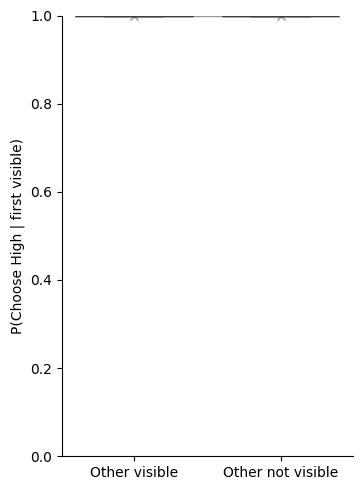

In [50]:
# Test plot for single trials
plot_probability_chose_wall.boxplot_probability_choose_wall(wall_choice_probabilities, ['Other visible', 'Other not visible'], ylabel="P(Choose High | first visible)")

In [22]:
# repeat for all datasets
df_all, trial_list_all = prepare_data.prepare_data(data_folder, json_filenames_all_social, combine=False) 

filepath: C:\Users\tomha\OneDrive\PhD\SWC\data\first_experiments_2409\240913\2024-09-13_11-31-00_YansuJerrySocial.json
Data is from period before 2024-09-13 00:00:00
Running dataframe through playerinfo_playerposition_conversion.
Loading complete.
Preprocessing complete.
filepath: C:\Users\tomha\OneDrive\PhD\SWC\data\second_experiments_2409\240927\2024-09-27_14-25-20_SaraEmilySocial.json
Loading complete.
Preprocessing complete.
filepath: C:\Users\tomha\OneDrive\PhD\SWC\data\third_experiments_2410\241017\2024-10-17_14-28-40_ShamirAbigailSocial.json
Loading complete.
Preprocessing complete.
filepath: C:\Users\tomha\OneDrive\PhD\SWC\data\fourth_experiments_2410\241017\2024-10-17_16-41-38_ZimoElsaSocial.json
Loading complete.
Preprocessing complete.
filepath: C:\Users\tomha\OneDrive\PhD\SWC\data\fifth_experiments_241112\2024-11-12_13-31-14_KhadijaWendySocial.json
Loading complete.
Preprocessing complete.
filepath: C:\Users\tomha\OneDrive\PhD\SWC\data\sixth_experiments_241112\2024-11-12_15

In [77]:
# Test across all sessions for player_id = 0,  P(H | H first vis; Other vis)
aaa = np.full(len(trial_list_all), np.nan)
bbb = np.full(len(trial_list_all), np.nan)
trial_list_index = 0
inferred_choice=False
debug=True
visible_wall_index = 0
chosen_wall_index = 0
current_fov = 110

for i, trial_list in enumerate(trial_list_all):

    # filter trial list for HighLow trialtype
    trial_indices = get_indices.get_trials_trialtype(trial_list, trial_type=trial_type)
    trial_list_filtered = [trial_list[i] for i in trial_indices]

    player_id = 1
    # get Other visibility for this trial list
    orientation_angle_to_other_session = get_angle_of_opponent_from_player_session(player_id, trial_list_filtered)
    other_visible_session = get_other_visible_session(orientation_angle_to_other_session, current_fov)
    
    aaa[i] = probability_chose_wall_conditioned_on_wall_and_other_visibility(trial_list_filtered, other_visible_session,
                                                                           player_id, visible_wall_index, chosen_wall_index,
                                                                           inferred_choice, current_fov,
                                                                           inverse_other_visible=False, debug=debug)
    bbb[i] = probability_chose_wall_conditioned_on_wall_and_other_visibility(trial_list_filtered, other_visible_session,
                                                                           player_id, visible_wall_index, chosen_wall_index,
                                                                           inferred_choice, current_fov,
                                                                           inverse_other_visible=True, debug=debug)
    
wall_choice_probabilities = [aaa,bbb]

Next session, player_id 1
player_choice, inferred status False is:
[nan  8.  8.  4.  4.  3. nan  3. nan  4.  3. nan  8. nan  5. nan nan nan
  1. nan  2.  8.  2.  7.  3. nan nan  4.  5.  8. nan nan nan  2. nan nan
 nan  6. nan  7. nan  4.  2.  5.  4.  3. nan  1. nan nan nan nan nan nan
 nan  3. nan  5. nan  1. nan  4.  2.]
player choice array:
[4. 3. 8. 5. 1. 2. 7. 3. 5. 2. 4. 4.]
given wall chosen array:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
given wall chosen true indices:
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),)
Len other_visible_trial_indices: 63
Len player_choice_exists_indices: 33
Len high_wall_initially_visible_indices: 12
Len player_chose_given_wall_indices: 12
Probability player chose wall given these conditions: 1.0
Next session, player_id 1
player_choice, inferred status False is:
[ 2. nan nan  4.  3. nan nan  3. nan  5. nan  6.  1.  6.  2.  3.  4.  1.
 nan  6. nan  4.  7. nan  5.  2. nan  8.  7.  1.  1.  2.  7. nan nan  1.
  4.  2. nan]
player choice array:


In [78]:
# Test across all sessions for player_id = 1, P(H | H first vis; Other vis)
aa = np.full(len(trial_list_all), np.nan)
bb = np.full(len(trial_list_all), np.nan)
trial_list_index = 0
inferred_choice=True
debug=True
visible_wall_index = 0
chosen_wall_index = 0
current_fov = 110

for i, trial_list in enumerate(trial_list_all):

    # filter trial list for HighLow trialtype
    trial_indices = get_indices.get_trials_trialtype(trial_list, trial_type=trial_type)
    trial_list_filtered = [trial_list[i] for i in trial_indices]

    player_id = 0
    # get Other visibility for this trial list
    orientation_angle_to_other_session = get_angle_of_opponent_from_player_session(player_id, trial_list_filtered)
    other_visible_session = get_other_visible_session(orientation_angle_to_other_session, current_fov)
    
    aa[i] = probability_chose_wall_conditioned_on_wall_and_other_visibility(trial_list_filtered, other_visible_session,
                                                                           player_id, visible_wall_index, chosen_wall_index,
                                                                           inferred_choice, current_fov,
                                                                           inverse_other_visible=False, debug=debug)
    bb[i] = probability_chose_wall_conditioned_on_wall_and_other_visibility(trial_list_filtered, other_visible_session,
                                                                           player_id, visible_wall_index, chosen_wall_index,
                                                                           inferred_choice, current_fov,
                                                                           inverse_other_visible=True, debug=debug)
    
wall_choice_probabilities = [aa,bb]

Next session, player_id 0
player_choice, inferred status True is:
[nan  2.  6. nan  4.  8.  4.  7.  6.  7.  1. nan  8.  5.  5.  8.  3.  6.
 nan  1.  3. nan  2.  7. nan nan  6.  4.  6.  7. nan  7.  3.  4.  2. nan
  3.  1.  6.  2.  5.  5.  4.  5.]
player choice array:
[2. 4. 7. 7. 5. 4. 2. 5. 5. 5.]
given wall chosen array:
[1. 1. 1. 1. 0. 1. 1. 1. 1. 0.]
given wall chosen true indices:
(array([0, 1, 2, 3, 5, 6, 7, 8]),)
Len other_visible_trial_indices: 44
Len player_choice_exists_indices: 35
Len high_wall_initially_visible_indices: 10
Len player_chose_given_wall_indices: 8
Probability player chose wall given these conditions: 0.8
Next session, player_id 0
player_choice, inferred status True is:
[ 5.  5. nan  2.  5. nan  2.  1. nan  1.  2.  3.  2.  1.  2.  6.  1.  7.
 nan  6. nan  8.  5.  3.  4.  3.  1.  1.  7.  2.  8.  1.  1.  6.  2. nan
  7.  4.  1.  2.  1.  8.  8.  3.  5. nan  2.  5.  1.  6. nan  1.  8. nan
 nan  7. nan  7.]
player choice array:
[3. 1. 7. 3. 7. 2. 8. 1. 1. 8. 2. 8.]
g

d:\tom\documents\swc\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
d:\tom\documents\swc\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
d:\tom\documents\swc\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player choice array:
[4. 1. 5.]
given wall chosen array:
[0. 0. 1.]
given wall chosen true indices:
(array([2]),)
Len other_visible_trial_indices: 7
Len player_choice_exists_indices: 3
Len high_wall_initially_visible_indices: 3
Len player_chose_given_wall_indices: 1
Probability player chose wall given these conditions: 0.3333333333333333
Next session, player_id 0
player_choice, inferred status True is:
[nan  1.  1.  7. nan  4. nan  2.  5.  7.  1. nan  3. nan  4.  4.  6.  4.
 nan  2. nan  8. nan nan  8. nan nan nan nan  4. nan nan  7.  6.  4.  1.
 nan  5. nan  4.  2. nan  4.  4.  2.  8.  1.  2. nan nan  8.  7.  4. nan
  3.  7.  5. nan  6.  3. nan  2. nan nan  5. nan  7. nan  8.  7.  2.  5.]
player choice array:
[4. 2. 6. 4. 4. 8. 4. 5. 7.]
given wall chosen array:
[1. 1. 0. 1. 1. 1. 1. 1. 1.]
given wall chosen true indices:
(array([0, 1, 3, 4, 5, 6, 7, 8]),)
Len other_visible_trial_indices: 72
Len player_choice_exists_indices: 45
Len high_wall_initially_visible_indices: 9
Len player_cho

d:\tom\documents\swc\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
d:\tom\documents\swc\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
d:\tom\documents\swc\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[nan  7.  2.  5. nan  1.  2.  6.  1. nan  5.  2.  2. nan  2.  8. nan  7.
  2.  8.  1. nan  5. nan  1.  1.  3.  5.  2.  5.  2.  6.  2.  3.  3.  5.
 nan]
player choice array:
[2. 8. 2. 5. 3. 5.]
given wall chosen array:
[0. 1. 1. 1. 1. 1.]
given wall chosen true indices:
(array([1, 2, 3, 4, 5]),)
Len other_visible_trial_indices: 37
Len player_choice_exists_indices: 29
Len high_wall_initially_visible_indices: 6
Len player_chose_given_wall_indices: 5
Probability player chose wall given these conditions: 0.8333333333333334
Next session, player_id 0
player_choice, inferred status True is:
[ 1.  1.  7.  4.  4.  5.  8.  6.  4.  8. nan  2. nan  7.  1.  2. nan  3.
  5.  3.  6.  8.  2.  8.  1. nan  6.  3.  4.  5.  7.  5.  8.  5.  3.  3.
  6.  8. nan  4.  1.  8. nan nan  5.  3.  5. nan  8.  4. nan  1.  2.  2.
  4. nan]
player choice array:
[4. 8. 2. 3. 6. 2. 3. 4. 5. 1. 2.]
given wall chosen array:
[1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1.]
given wall chosen true in

d:\tom\documents\swc\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)


player_choice, inferred status True is:
[ 6.  1. nan  7.  3.  6.  1. nan nan  8. nan nan  3.  3.  5.  4. nan nan
  3.  8.  4.  1.  3.  3.  1.  2. nan  3. nan  6. nan nan  5.  5.  5.  8.
 nan  6.  8. nan  2.  2.  1.  7.]
player choice array:
[3. 8. 3. 4. 3. 8. 8. 2.]
given wall chosen array:
[1. 1. 0. 1. 0. 1. 1. 1.]
given wall chosen true indices:
(array([0, 1, 3, 5, 6, 7]),)
Len other_visible_trial_indices: 44
Len player_choice_exists_indices: 31
Len high_wall_initially_visible_indices: 8
Len player_chose_given_wall_indices: 6
Probability player chose wall given these conditions: 0.75
Next session, player_id 0


d:\tom\documents\swc\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
d:\tom\documents\swc\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[ 3.  2. nan  1.  6.  2. nan  4.  2.  4.  8.  6. nan  8. nan nan  8.  8.
  6.  4.  4. nan  6.  7.  4.  2.  3.  5.  3.  7.  1.  1. nan  6.  5.  4.
  2.  7. nan nan nan  7.  1.  5.  2.  4.  4. nan  4.  4. nan  4. nan  6.
  5.  6.  8. nan  3. nan  5.  5.  2.  5.  2.  3.  3.  4.  4.  8.  7.  6.
 nan nan  1.  1.  5.  2.  8.  6.  2.  4. nan  3. nan  8.  1. nan  1. nan
 nan  3.]
player choice array:
[3. 1. 8. 8. 8. 7. 3. 3. 6. 5. 1. 4. 6. 8. 2. 3. 4. 4. 7. 1. 3. 8. 1.]
given wall chosen array:
[1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
given wall chosen true indices:
(array([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22]),)
Len other_visible_trial_indices: 92
Len player_choice_exists_indices: 70
Len high_wall_initially_visible_indices: 23
Len player_chose_given_wall_indices: 22
Probability player chose wall given these conditions: 0.9565217391304348
Next session, player_id 0


d:\tom\documents\swc\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
d:\tom\documents\swc\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
d:\tom\documents\swc\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[nan nan nan nan nan nan  2.  6.  6.  8.  6. nan  1.  3.  7.  4.  3.  5.
 nan  3. nan nan nan nan  6.  5.  5. nan nan  7.  1.  4. nan  5.  1.  4.
 nan nan nan  6.  1. nan nan nan  1.  8. nan nan  8. nan  7.  4.  8.  1.]
player choice array:
[6. 8. 7. 1. 1. 7. 8.]
given wall chosen array:
[1. 1. 1. 1. 1. 1. 1.]
given wall chosen true indices:
(array([0, 1, 2, 3, 4, 5, 6]),)
Len other_visible_trial_indices: 54
Len player_choice_exists_indices: 30
Len high_wall_initially_visible_indices: 7
Len player_chose_given_wall_indices: 7
Probability player chose wall given these conditions: 1.0
Next session, player_id 0
player_choice, inferred status True is:
[ 7. nan  8.  8.  7.  2.  6.  6.  6.  5.  6.  8.  5. nan  6.  6.  1.  7.
 nan  8.  8.  3.  8.]
player choice array:
[7. 6. 7.]
given wall chosen array:
[1. 1. 0.]
given wall chosen true indices:
(array([0, 1]),)
Len other_visible_trial_indices: 23
Len player_choice_exists_indices: 20
Len high_wall_initia

d:\tom\documents\swc\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
d:\tom\documents\swc\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
d:\tom\documents\swc\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[ 7.  7.  5.  8.  6.  2.  3.  7.  3.  1.  7.  7.  6.  5.  5.  4.  3.  3.
  3. nan  2.  7.  6.  3.  7.  5.  4.  2.  8.  6.  8.  6.  2.  8.  3.  6.
  2.]
player choice array:
[7. 7. 6. 5. 2. 7. 5. 8. 8. 8. 2.]
given wall chosen array:
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
given wall chosen true indices:
(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),)
Len other_visible_trial_indices: 37
Len player_choice_exists_indices: 36
Len high_wall_initially_visible_indices: 11
Len player_chose_given_wall_indices: 10
Probability player chose wall given these conditions: 0.9090909090909091
Next session, player_id 0
player_choice, inferred status True is:
[nan  4.  4.  8.  6.  5.  5.  7.  8.  2.  8.  8.  7.  1.  4.  8.  8.  2.
  8.  8.  1.  8.  4.  5.  1.  1.  4.  4.  3.  6.  3.  8.  1.  7.  8.  3.
  1.  3.  4.  2.  3.  5.  1.  2.  6.  5.  6.  3.  7. nan  7.  1.  2.  1.
  3.  5.]
player choice array:
[4. 8. 5. 2. 8. 4. 8. 8. 3. 6. 8. 3. 1. 2.]
given wall chosen a

d:\tom\documents\swc\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
d:\tom\documents\swc\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
d:\tom\documents\swc\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[ 7.  2.  2.  7.  2.  6.  4.  3.  8.  3.  8.  5.  4. nan  2.  6.  5.  7.
  4.  4.  8.  5.  7.  3.]
player choice array:
[2. 3. 5. 4. 6. 4. 5. 7.]
given wall chosen array:
[1. 1. 1. 1. 1. 1. 1. 1.]
given wall chosen true indices:
(array([0, 1, 2, 3, 4, 5, 6, 7]),)
Len other_visible_trial_indices: 24
Len player_choice_exists_indices: 23
Len high_wall_initially_visible_indices: 8
Len player_chose_given_wall_indices: 8
Probability player chose wall given these conditions: 1.0
Next session, player_id 0
player_choice, inferred status True is:
[ 3.  2.  7.  7.  1.  6.  8. nan  1.  7.  2. nan  5.  8.  1.  7.  8.  8.
  2.  5.  5.  7.  5.  7.  7.  6.  5.  4.  1.  6.  3.  5.  2. nan  4.  7.
 nan  1.  6.  3. nan  7.  4.  8.  8.  4.  7.  6.  8.  4.  4.  2.  3.  7.
  2.  7.  2.  7.  8.  8.  5.  2.  5.  7.  2.  3.  6.  6.  3.]
player choice array:
[2. 6. 1. 3. 4. 4. 7. 4. 7. 3.]
given wall chosen array:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
given wall chosen true ind

d:\tom\documents\swc\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
d:\tom\documents\swc\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
d:\tom\documents\swc\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[ 8.  3.  5.  3. nan  7.  3. nan  8.  3.  1.  5. nan  7.  2.  5.  1. nan
  8.  5.  6.  5.  3. nan nan nan  8.  8.  6.  1.  1.  2.  8.  6.  5.  6.
 nan]
player choice array:
[7. 1. 1. 1. 1. 8. 5. 6.]
given wall chosen array:
[1. 1. 1. 1. 1. 0. 1. 1.]
given wall chosen true indices:
(array([0, 1, 2, 3, 4, 6, 7]),)
Len other_visible_trial_indices: 37
Len player_choice_exists_indices: 29
Len high_wall_initially_visible_indices: 8
Len player_chose_given_wall_indices: 7
Probability player chose wall given these conditions: 0.875
Next session, player_id 0
player_choice, inferred status True is:
[nan  4.  1.  3. nan  1. nan nan  2.  5.  3.  5.  7.  8.  2.  7.  5. nan
  1.  6.  1.  3. nan  6.  2. nan  6.  8.  1.  7.  1.  4.  7.  7. nan  5.
  3. nan  2. nan  5.  2.  1.  8.  7.  1.  3.  7. nan  1.  1.  4.  5. nan
 nan nan  8.  6.  7.  6.  1.  5. nan nan nan  2.  2.  8.  2.  6.  4.  3.]
player choice array:
[4. 5. 8. 5. 6. 1. 6. 1. 5. 7. 4. 8. 2. 8. 2. 6. 4.

d:\tom\documents\swc\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)


player_choice, inferred status True is:
[ 6.  7. nan nan  6.  7. nan  3.  5.  6. nan  8.  3.  6.  6.  5. nan  1.
 nan  1.  4.  3.  4. nan]
player choice array:
[4.]
given wall chosen array:
[1.]
given wall chosen true indices:
(array([0]),)
Len other_visible_trial_indices: 24
Len player_choice_exists_indices: 17
Len high_wall_initially_visible_indices: 1
Len player_chose_given_wall_indices: 1
Probability player chose wall given these conditions: 1.0
Next session, player_id 0


d:\tom\documents\swc\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
d:\tom\documents\swc\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[ 8.  2.  2. nan  1. nan  1. nan  7.  4. nan  4. nan  2.  8.  6.  6.  5.
  8.  2.  4. nan  3. nan  6.  3. nan  6.  1.  8.  5.  7.  5.  6.  4.  6.
 nan  4.  2.  2.  7.  8. nan nan  2.  1.  5.  6.  4.  6.  5.  1.  4. nan
  8.  3. nan  8.  5.  7.  6.  8.  8.  4.  4.  5.  2.  5.  1.]
player choice array:
[1. 4. 2. 8. 6. 5. 5. 6. 1. 4. 4. 8. 7. 8. 5.]
given wall chosen array:
[0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1.]
given wall chosen true indices:
(array([ 1,  2,  4,  6,  8,  9, 10, 11, 13, 14]),)
Len other_visible_trial_indices: 69
Len player_choice_exists_indices: 56
Len high_wall_initially_visible_indices: 15
Len player_chose_given_wall_indices: 10
Probability player chose wall given these conditions: 0.6666666666666666
Next session, player_id 0


d:\tom\documents\swc\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
d:\tom\documents\swc\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
d:\tom\documents\swc\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[ 6.  8. nan  6.  5.  6.  3.  2.  7.  4.  6. nan  2.  3.  5.  7.  7.  7.
  6.  8.  3.  4.  6.  2.  5.  5.  4. nan  4.  8.  4.  3.  6.]
player choice array:
[6. 7. 7. 8. 6. 4. 4. 8.]
given wall chosen array:
[0. 1. 0. 1. 1. 0. 1. 1.]
given wall chosen true indices:
(array([1, 3, 4, 6, 7]),)
Len other_visible_trial_indices: 33
Len player_choice_exists_indices: 30
Len high_wall_initially_visible_indices: 8
Len player_chose_given_wall_indices: 5
Probability player chose wall given these conditions: 0.625
Next session, player_id 0
player_choice, inferred status True is:
[ 6.  6.  5.  8.  2.  6.  1.  5.  1.  3.  8.  7. nan  6.  2.  5.  5.  6.
  7.  3.  2.  5.  8.  1.  5.  8.  2.  6.  6. nan  7.  2.  8.  5.  7.  4.
  4.  6.  1.  7.  8.  4.  3.  6.  4. nan  4.  1.  7.  7.  5. nan nan  6.
  3.  3.  4.  8.  4. nan  3.  8.  4.  1.  1.]
player choice array:
[5. 1. 7. 2. 6. 5. 6. 1. 8. 4. 6. 8. 4.]
given wall chosen array:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

d:\tom\documents\swc\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
d:\tom\documents\swc\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
d:\tom\documents\swc\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[ 7.  8.  3. nan  7.  1.  5. nan  4.  6.  8.  3. nan  2.  7. nan nan nan
  7. nan  6.  5. nan  6. nan nan  8.  6.  7.  6.  6.  5.  1.  8.  5.  3.
 nan  8.  3.  2.  7.  6.  4.  6.  4. nan  4.  5.  8.  4.  8.  2.  5.  7.
  6.  5.]
player choice array:
[5. 3. 7. 6. 1. 8. 8. 8. 6.]
given wall chosen array:
[1. 0. 1. 0. 1. 1. 1. 1. 1.]
given wall chosen true indices:
(array([0, 2, 4, 5, 6, 7, 8]),)
Len other_visible_trial_indices: 56
Len player_choice_exists_indices: 44
Len high_wall_initially_visible_indices: 9
Len player_chose_given_wall_indices: 7
Probability player chose wall given these conditions: 0.7777777777777778
Next session, player_id 0
player_choice, inferred status True is:
[nan nan  4.  4.  3.  4.  7.  8. nan  7.  5.  3.  8.  6.  7.  6.  3.  7.
  5.  4.  8.  3.  4.  4.  6.  2.  4.  3.  3.  7.  7.  3. nan  4.  4.  1.
  8.  7.  5. nan nan  5. nan nan  6.  4.  4.  8.  6.  6.  2.  8.  5.  5.
 nan  4.  4. nan  1.  8.  1.  2. nan  5.  2. nan  

d:\tom\documents\swc\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
d:\tom\documents\swc\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
d:\tom\documents\swc\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[nan nan  6.  7.  7.  2.  1.  5.  4. nan  4.  5. nan  5.  5.  3.  7.  3.
  4.  2.  3.  7.  7. nan  3.  5.  4.  6.  4.  1.  1.  8.  3.  4.  5.  4.
  2. nan nan  7.]
player choice array:
[7. 2. 5. 2. 4. 6. 1. 2.]
given wall chosen array:
[1. 0. 0. 1. 1. 1. 0. 0.]
given wall chosen true indices:
(array([0, 3, 4, 5]),)
Len other_visible_trial_indices: 40
Len player_choice_exists_indices: 33
Len high_wall_initially_visible_indices: 8
Len player_chose_given_wall_indices: 4
Probability player chose wall given these conditions: 0.5
Next session, player_id 0
player_choice, inferred status True is:
[nan nan  7.  6.  6.  6.  7.  6. nan  2. nan  8.  1.  2.  3.  1.  7.  1.
  2.  4.  7.  8. nan  3.  5.  2.  2. nan  6.  2. nan nan  7.  2.  3. nan
  5.  8. nan  5.  4.  5. nan  2.  6.  2.  7.  3.  7. nan  3. nan nan  6.
  3.  3.  4.  4.  3. nan  2.  6. nan  3.  7.  6.  8. nan  2. nan nan nan
  5.  2.  1.  8.  7. nan nan]
player choice array:
[7. 6. 2. 2. 7. 1. 7.

d:\tom\documents\swc\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
d:\tom\documents\swc\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
d:\tom\documents\swc\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[ 1.  3.  3.  1.  5.  1. nan  1.  4. nan  6.  1.  4.  7.  2.  1.  3.  6.
  8.  6. nan  8. nan  8.  5.  5.  2.  5.  1.  1.  4.  3.  5.  3.  6.  3.
  6.]
player choice array:
[6. 5. 5. 3.]
given wall chosen array:
[1. 1. 1. 1.]
given wall chosen true indices:
(array([0, 1, 2, 3]),)
Len other_visible_trial_indices: 37
Len player_choice_exists_indices: 33
Len high_wall_initially_visible_indices: 4
Len player_chose_given_wall_indices: 4
Probability player chose wall given these conditions: 1.0
Next session, player_id 0
player_choice, inferred status True is:
[ 1. nan  2.  4.  1.  2.  2.  4.  7.  1.  4.  2.  2.  4.  7.  3.  3.  6.
  3.  3.  7. nan  5.  3.  4. nan  7.  3.  3.  6.  1.  5.  5.  5.  1.  7.
 nan  1. nan  4.  7.  8.  1. nan  7.  5.  1. nan  3.  3.]
player choice array:
[1. 1. 7. 3. 3. 3. 1. 1. 7. 7.]
given wall chosen array:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
given wall chosen true indices:
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),)
Len other_vis

d:\tom\documents\swc\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
d:\tom\documents\swc\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
d:\tom\documents\swc\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[ 7.  3.  2.  5. nan  6.  2. nan  6.  3.  6. nan  6. nan  1.  6.  1.  7.
 nan nan  4.  7.  1.  8. nan  8. nan  6.  8.  6.]
player choice array:
[3. 6. 3. 6. 6. 7. 4. 8. 6.]
given wall chosen array:
[1. 1. 1. 1. 1. 1. 1. 1. 0.]
given wall chosen true indices:
(array([0, 1, 2, 3, 4, 5, 6, 7]),)
Len other_visible_trial_indices: 30
Len player_choice_exists_indices: 22
Len high_wall_initially_visible_indices: 9
Len player_chose_given_wall_indices: 8
Probability player chose wall given these conditions: 0.8888888888888888
Next session, player_id 0
player_choice, inferred status True is:
[ 2.  2.  6. nan  1.  2.  6.  3.  4.  8.  8.  4.  7.  5.  1. nan nan  6.
  4.  7. nan  7.  7.  4.  8.  3.  3.  2. nan  5.  7.  6.  8. nan  7.  1.
  2.  1.  3.  1.  8.  4.  6.  5.  5.  7.  7. nan  3.  8.  1.  4.  4.  4.
  3.  1.  1. nan  2.  8. nan  7.  4.  4.  5.]
player choice array:
[6. 1. 3. 1. 3. 8. 7. 1. 8. 6. 5. 2. 8. 4. 4.]
given wall chosen array:
[1. 1. 1. 1. 1

d:\tom\documents\swc\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
d:\tom\documents\swc\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
d:\tom\documents\swc\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[ 6.  6. nan  8.  1.  8.  5.  8.  3.  5.  2.  5.  7.  1.  4.  2.  6.  1.
  5.  8.  6.  1.  4.  8. nan  3.  1.  7.  8.  1.]
player choice array:
[5. 2. 5. 1. 8. 1.]
given wall chosen array:
[1. 1. 0. 1. 1. 0.]
given wall chosen true indices:
(array([0, 1, 3, 4]),)
Len other_visible_trial_indices: 30
Len player_choice_exists_indices: 28
Len high_wall_initially_visible_indices: 6
Len player_chose_given_wall_indices: 4
Probability player chose wall given these conditions: 0.6666666666666666
Next session, player_id 0
player_choice, inferred status True is:
[ 7.  2.  6. nan  1.  1.  2.  7.  7. nan nan  1.  1.  4.  1. nan  5.  1.
  1.  6.  2. nan  5.  3.  7.  6.  2.  6. nan  2.  4.  5.  2.  2.  3.  5.
 nan  1. nan nan  5.  8.  2.  3.  7.  2.  1.  8.  4.  4.  8.  8.  6.  3.
  3.  1.  5.  5.  4.  7. nan  8.  7.  5.  3.  7. nan  5.  3.  1.  6. nan
  2.  3.  1.  1.  5.  7.  8. nan]
player choice array:
[6. 1. 1. 4. 5. 5. 7. 8. 6. 5. 5. 7. 8. 3. 7. 6. 3. 1.]

d:\tom\documents\swc\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)


player_choice, inferred status True is:
[nan  5.  4.  8. nan  2.  6.  5.  3. nan  8.  4. nan  5.  2.  1.  5.  4.
  6. nan  1. nan  4.  4.  4.  8.  5. nan nan  5. nan  6.]
player choice array:
[5. 8. 6. 5. 1. 4. 4. 5.]
given wall chosen array:
[1. 1. 1. 1. 0. 1. 1. 1.]
given wall chosen true indices:
(array([0, 1, 2, 3, 5, 6, 7]),)
Len other_visible_trial_indices: 32
Len player_choice_exists_indices: 23
Len high_wall_initially_visible_indices: 8
Len player_chose_given_wall_indices: 7
Probability player chose wall given these conditions: 0.875
Next session, player_id 0


d:\tom\documents\swc\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
d:\tom\documents\swc\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[ 5.  2.  6.  7.  1.  8.  5.  6. nan nan  2.  3.  2.  1. nan nan  2.  3.
  5.  6.  8.  8.  5.  5.  3.  7.  7.  7.  3.  4.  3.  4.  1.  1.  6. nan
  3.  2.  7.  8.  5.  2. nan  1.  6.  2. nan  4.  5.  8.  7.  8.  4.  5.
  6.  5. nan  1.  3.  3.  8.  5.  1.  1.  2.  3. nan  1.  1.  8.  6. nan
  2. nan  1.  2.  7.  1.  8.  4.  3. nan  7.]
player choice array:
[1. 2. 3. 5. 8. 5. 7. 4. 1. 3. 5. 3. 5. 1. 2. 8. 2. 8.]
given wall chosen array:
[1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
given wall chosen true indices:
(array([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]),)
Len other_visible_trial_indices: 83
Len player_choice_exists_indices: 71
Len high_wall_initially_visible_indices: 18
Len player_chose_given_wall_indices: 17
Probability player chose wall given these conditions: 0.9444444444444444
Next session, player_id 0
player_choice, inferred status True is:
[ 8.  8.  3. nan nan  6.  7. nan nan  7.  2.  2. nan  3. 

d:\tom\documents\swc\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
d:\tom\documents\swc\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
d:\tom\documents\swc\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player choice array:
[8. 7. 2. 6. 1. 1. 4.]
given wall chosen array:
[1. 0. 1. 1. 1. 1. 1.]
given wall chosen true indices:
(array([0, 2, 3, 4, 5, 6]),)
Len other_visible_trial_indices: 32
Len player_choice_exists_indices: 22
Len high_wall_initially_visible_indices: 7
Len player_chose_given_wall_indices: 6
Probability player chose wall given these conditions: 0.8571428571428571
Next session, player_id 0
player_choice, inferred status True is:
[nan  3.  4.  8. nan nan  8.  3.  2.  3. nan  1.  8. nan  4. nan  3.  4.
  8.  6.  7.  3.  1.  7.  5. nan  1.  4.  6.  3.  8.  1.  8.  1.  2. nan
  3.  1.  5. nan  4.  8. nan  6.  6. nan  1. nan nan nan nan  1.  1.  6.
  1.  4.  4.  7.  6.  4. nan  1.  1.  8.  3.  1.  4.  2.  3.  4.  1.  7.
 nan  8.  1.  5.  7.  7.  8. nan  1.  7.]
player choice array:
[3. 4. 8. 3. 4. 8. 7. 4. 6. 1. 6. 1. 6. 4. 5.]
given wall chosen array:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
given wall chosen true indices:
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9,

d:\tom\documents\swc\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
d:\tom\documents\swc\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
d:\tom\documents\swc\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[ 1.  2.  5.  7.  3. nan  2.  4.  2. nan  4.  5.  3. nan  5.  1. nan  5.
  7. nan  7.  8.  3.  8.  8. nan  8.  8.  2.  1.  3.  8.  7.  6.  5.  7.
  8. nan  4.  4.  4.  5.  5.  4.  2.  3.  8.  7.  7. nan nan  6.  3.  5.
  4.  2.  8. nan  5.  8.  5.  8.  6.  6.  6.  7.  5.  4. nan nan  6.  7.
  5. nan  5. nan nan  4.  4.  4.  6.  3.  3.  3. nan  3.  4.  4.  4.  4.
  3.  4.  1.  5.  1.  5.]
player choice array:
[1. 2. 3. 4. 7. 7. 8. 8. 5. 8. 4. 7. 3. 2. 5. 8. 6. 6. 7. 5. 6. 4. 4. 3.
 4. 3. 4. 5.]
given wall chosen array:
[1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 1.]
given wall chosen true indices:
(array([ 0,  1,  4,  6, 15, 16, 25, 27]),)
Len other_visible_trial_indices: 96
Len player_choice_exists_indices: 80
Len high_wall_initially_visible_indices: 28
Len player_chose_given_wall_indices: 8
Probability player chose wall given these conditions: 0.2857142857142857
Next session, player_id 0
player_choice, infe

In [37]:
len(filtered_trail_list_a_list[21])

11

In [ ]:
# P(H | H first visible; Other visible) 
# combined player_ids 1 and 0, for all sessions

a = np.full(len(trial_list_all)*2, np.nan)
b = np.full(len(trial_list_all)*2, np.nan)
filtered_trail_list_a_list = []
filtered_trial_list_choice_a_list = []
filtered_trail_list_b_list = []
filtered_trial_list_choice_b_list = []
trial_list_index = 0
inferred_choice=True
debug=True
visible_wall_index = 0
chosen_wall_index = 0
current_fov = 110

for i in range(0,len(trial_list_all)*2, 2):

    trial_list = trial_list_all[trial_list_index]

    # filter trial list for HighLow trialtype
    trial_indices = get_indices.get_trials_trialtype(trial_list, trial_type=trial_type)
    trial_list_filtered = [trial_list[i] for i in trial_indices]

    player_id = 0
    # get Other visibility for this trial list
    orientation_angle_to_other_session = get_angle_of_opponent_from_player_session(player_id, trial_list_filtered)
    other_visible_session = get_other_visible_session(orientation_angle_to_other_session, current_fov)
    
    (a[i],
    filtered_trial_indices_a,
    filtered_trial_choice_indices_a) = probability_chose_wall_conditioned_on_wall_and_other_visibility(trial_list_filtered, other_visible_session,
                                                                           player_id, visible_wall_index, chosen_wall_index,
                                                                           inferred_choice, current_fov,
                                                                           inverse_other_visible=False,
                                                                            return_trial_indices=True, debug=debug)
    (b[i],
    filtered_trial_indices_b,
    filtered_trial_choice_indices_b)  = probability_chose_wall_conditioned_on_wall_and_other_visibility(trial_list_filtered, other_visible_session,
                                                                           player_id, visible_wall_index, chosen_wall_index,
                                                                           inferred_choice, current_fov,
                                                                           inverse_other_visible=True,
                                                                            return_trial_indices=True, debug=debug)
    
    filtered_trail_list_a_list.append(filtered_trial_indices_a)
    filtered_trial_list_choice_a_list.append(filtered_trial_choice_indices_a)
    filtered_trail_list_b_list.append(filtered_trial_indices_b)
    filtered_trial_list_choice_b_list.append(filtered_trial_choice_indices_b)
    
    player_id = 1
    # get Other visibility for this trial list
    orientation_angle_to_other_session = get_angle_of_opponent_from_player_session(player_id, trial_list_filtered)
    other_visible_session = get_other_visible_session(orientation_angle_to_other_session, current_fov)
    
    (a[i+1],
    filtered_trial_indices_a,
    filtered_trial_choice_indices_a) = probability_chose_wall_conditioned_on_wall_and_other_visibility(trial_list_filtered, other_visible_session,
                                                                             player_id, visible_wall_index, chosen_wall_index,
                                                                             inferred_choice, current_fov,
                                                                             inverse_other_visible=False,
                                                                              return_trial_indices=True, debug=debug)
    (b[i+1],
    filtered_trial_indices_b,
    filtered_trial_choice_indices_b) = probability_chose_wall_conditioned_on_wall_and_other_visibility(trial_list_filtered, other_visible_session,
                                                                             player_id, visible_wall_index, chosen_wall_index,
                                                                             inferred_choice, current_fov,
                                                                             inverse_other_visible=True,
                                                                              return_trial_indices=True, debug=debug)
    

    filtered_trail_list_a_list.append(filtered_trial_indices_a)
    filtered_trial_list_choice_a_list.append(filtered_trial_choice_indices_a)
    filtered_trail_list_b_list.append(filtered_trial_indices_b)
    filtered_trial_list_choice_b_list.append(filtered_trial_choice_indices_b)
    
    trial_list_index += 1
    
    
wall_choice_probabilities = [a,b]

Next session, player_id 0
player_choice, inferred status True is:
[nan  2.  6. nan  4.  8.  4.  7.  6.  7.  1. nan  8.  5.  5.  8.  3.  6.
 nan  1.  3. nan  2.  7. nan nan  6.  4.  6.  7. nan  7.  3.  4.  2. nan
  3.  1.  6.  2.  5.  5.  4.  5.]
player choice array:
[2. 4. 7. 7. 5. 4. 2. 5. 5. 5.]
given wall chosen array:
[1. 1. 1. 1. 0. 1. 1. 1. 1. 0.]
given wall chosen true indices:
(array([0, 1, 2, 3, 5, 6, 7, 8]),)
Len other_visible_trial_indices: 44
Len player_choice_exists_indices: 35
Len high_wall_initially_visible_indices: 10
Len player_chose_given_wall_indices: 8
Probability player chose wall given these conditions: 0.8
Next session, player_id 0
player_choice, inferred status True is:
[ 5.  5. nan  2.  5. nan  2.  1. nan  1.  2.  3.  2.  1.  2.  6.  1.  7.
 nan  6. nan  8.  5.  3.  4.  3.  1.  1.  7.  2.  8.  1.  1.  6.  2. nan
  7.  4.  1.  2.  1.  8.  8.  3.  5. nan  2.  5.  1.  6. nan  1.  8. nan
 nan  7. nan  7.]
player choice array:
[3. 1. 7. 3. 7. 2. 8. 1. 1. 8. 2. 8.]
g

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[nan  1.  1.  7. nan  4. nan  2.  5.  7.  1. nan  3. nan  4.  4.  6.  4.
 nan  2. nan  8. nan nan  8. nan nan nan nan  4. nan nan  7.  6.  4.  1.
 nan  5. nan  4.  2. nan  4.  4.  2.  8.  1.  2. nan nan  8.  7.  4. nan
  3.  7.  5. nan  6.  3. nan  2. nan nan  5. nan  7. nan  8.  7.  2.  5.]
player choice array:
[4. 2. 6. 4. 4. 8. 4. 5. 7.]
given wall chosen array:
[1. 1. 0. 1. 1. 1. 1. 1. 1.]
given wall chosen true indices:
(array([0, 1, 3, 4, 5, 6, 7, 8]),)
Len other_visible_trial_indices: 72
Len player_choice_exists_indices: 45
Len high_wall_initially_visible_indices: 9
Len player_chose_given_wall_indices: 8
Probability player chose wall given these conditions: 0.8888888888888888
Next session, player_id 1
player_choice, inferred status True is:
[1. 7. 7. 2. 3. 6. 7. 6. 2. 8. 3. 1. 5. 5. 7. 7. 4. 8. 1. 5. 1. 4. 7. 5.
 5. 6. 2. 1. 4. 3.]


c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player choice array:
[6. 7. 4. 5.]
given wall chosen array:
[0. 1. 1. 1.]
given wall chosen true indices:
(array([1, 2, 3]),)
Len other_visible_trial_indices: 30
Len player_choice_exists_indices: 30
Len high_wall_initially_visible_indices: 4
Len player_chose_given_wall_indices: 3
Probability player chose wall given these conditions: 0.75
Next session, player_id 1
player_choice, inferred status True is:
[5. 2. 4. 6. 5. 7. 1. 8. 8. 4. 3. 4. 4. 3. 4. 1. 1. 8. 5. 3. 5. 7. 7. 4.
 3. 6. 8. 8. 3. 4. 2. 2. 6. 7. 7. 2. 1. 6. 3. 3. 5. 2. 4. 2. 2. 6. 8. 2.
 5.]
player choice array:
[8. 4. 3. 1. 5. 5. 7. 6. 8. 4. 2. 2. 4.]
given wall chosen array:
[1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1.]
given wall chosen true indices:
(array([ 0,  1,  2,  4,  6,  7,  8,  9, 11, 12]),)
Len other_visible_trial_indices: 49
Len player_choice_exists_indices: 49
Len high_wall_initially_visible_indices: 13
Len player_chose_given_wall_indices: 10
Probability player chose wall given these conditions: 0.7692307692307693
Ne

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[nan  7.  2.  5. nan  1.  2.  6.  1. nan  5.  2.  2. nan  2.  8. nan  7.
  2.  8.  1. nan  5. nan  1.  1.  3.  5.  2.  5.  2.  6.  2.  3.  3.  5.
 nan]
player choice array:
[2. 8. 2. 5. 3. 5.]
given wall chosen array:
[0. 1. 1. 1. 1. 1.]
given wall chosen true indices:
(array([1, 2, 3, 4, 5]),)
Len other_visible_trial_indices: 37
Len player_choice_exists_indices: 29
Len high_wall_initially_visible_indices: 6
Len player_chose_given_wall_indices: 5
Probability player chose wall given these conditions: 0.8333333333333334
Next session, player_id 0
player_choice, inferred status True is:
[ 1.  1.  7.  4.  4.  5.  8.  6.  4.  8. nan  2. nan  7.  1.  2. nan  3.
  5.  3.  6.  8.  2.  8.  1. nan  6.  3.  4.  5.  7.  5.  8.  5.  3.  3.
  6.  8. nan  4.  1.  8. nan nan  5.  3.  5. nan  8.  4. nan  1.  2.  2.
  4. nan]
player choice array:
[4. 8. 2. 3. 6. 2. 3. 4. 5. 1. 2.]
given wall chosen array:
[1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1.]
given wall chosen true in

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player choice array:
[2. 5. 6. 7. 1.]
given wall chosen array:
[1. 1. 1. 1. 1.]
given wall chosen true indices:
(array([0, 1, 2, 3, 4]),)
Len other_visible_trial_indices: 36
Len player_choice_exists_indices: 32
Len high_wall_initially_visible_indices: 5
Len player_chose_given_wall_indices: 5
Probability player chose wall given these conditions: 1.0
Next session, player_id 1
player_choice, inferred status True is:
[ 5.  6. nan  8.  5.  6.  4.  5.  4.  8.  8.  7.  5.  5.  7.  2.  6. nan
 nan  1.  2. nan  1.  1.  6.  8.  5.  4.  1.  8.  1.  3.  6.  4.  7.  7.
  7.  1.  6.  1.  2.  4. nan  4. nan nan  3. nan  2.  6.  8.  4.  6.  5.
  3.  8. nan]
player choice array:
[5. 5. 8. 1. 1. 6. 5. 2. 4. 3.]
given wall chosen array:
[1. 1. 1. 1. 1. 1. 1. 0. 1. 1.]
given wall chosen true indices:
(array([0, 1, 2, 3, 4, 5, 6, 8, 9]),)
Len other_visible_trial_indices: 57
Len player_choice_exists_indices: 48
Len high_wall_initially_visible_indices: 10
Len player_chose_given_wall_indices: 9
Probability pl

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)


player_choice, inferred status True is:
[ 6.  1. nan  7.  3.  6.  1. nan nan  8. nan nan  3.  3.  5.  4. nan nan
  3.  8.  4.  1.  3.  3.  1.  2. nan  3. nan  6. nan nan  5.  5.  5.  8.
 nan  6.  8. nan  2.  2.  1.  7.]
player choice array:
[3. 8. 3. 4. 3. 8. 8. 2.]
given wall chosen array:
[1. 1. 0. 1. 0. 1. 1. 1.]
given wall chosen true indices:
(array([0, 1, 3, 5, 6, 7]),)
Len other_visible_trial_indices: 44
Len player_choice_exists_indices: 31
Len high_wall_initially_visible_indices: 8
Len player_chose_given_wall_indices: 6
Probability player chose wall given these conditions: 0.75
Next session, player_id 0


c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[ 3.  2. nan  1.  6.  2. nan  4.  2.  4.  8.  6. nan  8. nan nan  8.  8.
  6.  4.  4. nan  6.  7.  4.  2.  3.  5.  3.  7.  1.  1. nan  6.  5.  4.
  2.  7. nan nan nan  7.  1.  5.  2.  4.  4. nan  4.  4. nan  4. nan  6.
  5.  6.  8. nan  3. nan  5.  5.  2.  5.  2.  3.  3.  4.  4.  8.  7.  6.
 nan nan  1.  1.  5.  2.  8.  6.  2.  4. nan  3. nan  8.  1. nan  1. nan
 nan  3.]
player choice array:
[3. 1. 8. 8. 8. 7. 3. 3. 6. 5. 1. 4. 6. 8. 2. 3. 4. 4. 7. 1. 3. 8. 1.]
given wall chosen array:
[1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
given wall chosen true indices:
(array([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22]),)
Len other_visible_trial_indices: 92
Len player_choice_exists_indices: 70
Len high_wall_initially_visible_indices: 23
Len player_chose_given_wall_indices: 22
Probability player chose wall given these conditions: 0.9565217391304348
Next session, player_id 1


c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[ 1.  2. nan  1.  2.  4.  2.  5.  4.  3.  5.  6. nan  6.  4.  7.  3.  1.
  3.  8.  6.  4.  7.  3.  1.  2.  6.  1.  1. nan  5.  5.  8.  7.  6.  2.
  3.  6.  2.  5.  1.  4.  3.  7.  6.  1.  7.]
player choice array:
[4. 5. 7. 1. 5. 8. 6. 3. 1. 3. 1. 7.]
given wall chosen array:
[1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
given wall chosen true indices:
(array([ 0,  3,  4,  5,  6,  7,  8,  9, 10, 11]),)
Len other_visible_trial_indices: 47
Len player_choice_exists_indices: 44
Len high_wall_initially_visible_indices: 12
Len player_chose_given_wall_indices: 10
Probability player chose wall given these conditions: 0.8333333333333334
Next session, player_id 1
player_choice, inferred status True is:
[ 5.  3.  8.  7.  3.  6.  8.  5.  2.  2.  7.  4.  2.  8.  5.  4.  7.  4.
  4.  4.  4.  8.  8.  3.  5.  7.  8.  2.  8.  5.  7.  1.  4.  8. nan  3.
  8.  1.  2.  1.  8.  3.  3.  3.  4.  7.  3.  4.  1.  8.  5.  8.  4.  3.
  8.  4.  1. nan  3.  6.  7.  1.  6.  5.  7.  8.

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[nan nan nan nan nan nan  2.  6.  6.  8.  6. nan  1.  3.  7.  4.  3.  5.
 nan  3. nan nan nan nan  6.  5.  5. nan nan  7.  1.  4. nan  5.  1.  4.
 nan nan nan  6.  1. nan nan nan  1.  8. nan nan  8. nan  7.  4.  8.  1.]
player choice array:
[6. 8. 7. 1. 1. 7. 8.]
given wall chosen array:
[1. 1. 1. 1. 1. 1. 1.]
given wall chosen true indices:
(array([0, 1, 2, 3, 4, 5, 6]),)
Len other_visible_trial_indices: 54
Len player_choice_exists_indices: 30
Len high_wall_initially_visible_indices: 7
Len player_chose_given_wall_indices: 7
Probability player chose wall given these conditions: 1.0
Next session, player_id 0
player_choice, inferred status True is:
[ 7. nan  8.  8.  7.  2.  6.  6.  6.  5.  6.  8.  5. nan  6.  6.  1.  7.
 nan  8.  8.  3.  8.]
player choice array:
[7. 6. 7.]
given wall chosen array:
[1. 1. 0.]
given wall chosen true indices:
(array([0, 1]),)
Len other_visible_trial_indices: 23
Len player_choice_exists_indices: 20
Len high_wall_initia

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player choice array:
[2. 5. 5. 2. 2. 1.]
given wall chosen array:
[1. 1. 1. 1. 1. 0.]
given wall chosen true indices:
(array([0, 1, 2, 3, 4]),)
Len other_visible_trial_indices: 22
Len player_choice_exists_indices: 19
Len high_wall_initially_visible_indices: 6
Len player_chose_given_wall_indices: 5
Probability player chose wall given these conditions: 0.8333333333333334
Next session, player_id 1
player_choice, inferred status True is:
[nan  2. nan  7.  5.  7. nan  3.  4.  1.  2.  4. nan  2.  7.  6. nan  6.
  3.  1.  4.  7.  7.  6.  3.  5.  7. nan  7. nan nan  7.  1.  8.  1.  3.
  3.  5. nan nan  3.  6.  3.  6.  1.  7.  1.  2.  8.  8.  1.  2.  8. nan
  1.]
player choice array:
[5. 7. 6. 4. 7. 7. 6. 3. 7. 2. 8. 1.]
given wall chosen array:
[1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.]
given wall chosen true indices:
(array([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 11]),)
Len other_visible_trial_indices: 55
Len player_choice_exists_indices: 44
Len high_wall_initially_visible_indices: 12
Len player_

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[ 7.  7.  5.  8.  6.  2.  3.  7.  3.  1.  7.  7.  6.  5.  5.  4.  3.  3.
  3. nan  2.  7.  6.  3.  7.  5.  4.  2.  8.  6.  8.  6.  2.  8.  3.  6.
  2.]
player choice array:
[7. 7. 6. 5. 2. 7. 5. 8. 8. 8. 2.]
given wall chosen array:
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
given wall chosen true indices:
(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),)
Len other_visible_trial_indices: 37
Len player_choice_exists_indices: 36
Len high_wall_initially_visible_indices: 11
Len player_chose_given_wall_indices: 10
Probability player chose wall given these conditions: 0.9090909090909091
Next session, player_id 0
player_choice, inferred status True is:
[nan  4.  4.  8.  6.  5.  5.  7.  8.  2.  8.  8.  7.  1.  4.  8.  8.  2.
  8.  8.  1.  8.  4.  5.  1.  1.  4.  4.  3.  6.  3.  8.  1.  7.  8.  3.
  1.  3.  4.  2.  3.  5.  1.  2.  6.  5.  6.  3.  7. nan  7.  1.  2.  1.
  3.  5.]
player choice array:
[4. 8. 5. 2. 8. 4. 8. 8. 3. 6. 8. 3. 1. 2.]
given wall chosen a

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)


player_choice, inferred status True is:
[nan  4.  4.  7.  4.  1. nan  5.  6.  8. nan  1. nan  6.  7.  2.  4. nan
  7. nan  3.  5.  8. nan  5.  2.  2.  4.  2.  1.  1.  1.  6.  5. nan  3.
  1.  4.  2.  2.  5. nan  5.]
player choice array:
[4. 7. 1. 6. 1. 1. 5. 2. 5.]
given wall chosen array:
[1. 0. 0. 0. 0. 0. 1. 1. 1.]
given wall chosen true indices:
(array([0, 6, 7, 8]),)
Len other_visible_trial_indices: 43
Len player_choice_exists_indices: 34
Len high_wall_initially_visible_indices: 9
Len player_chose_given_wall_indices: 4
Probability player chose wall given these conditions: 0.4444444444444444
Next session, player_id 1
player_choice, inferred status True is:
[ 2.  1.  4.  4.  4.  3.  4. nan nan  3.  4. nan  7. nan nan  4.  7.  1.
 nan  4.  3.  2.  2.  3.  4.  3.  8.  7.  2.  1.  4. nan  1.  6.  3.  7.
 nan  2.  5.  3.  4.  7.  1.  7.  8.  7.  6.  5.  8. nan]


c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player choice array:
[2. 3. 7. 4. 3. 7. 7. 6. 5.]
given wall chosen array:
[1. 1. 0. 1. 1. 1. 1. 1. 1.]
given wall chosen true indices:
(array([0, 1, 3, 4, 5, 6, 7, 8]),)
Len other_visible_trial_indices: 50
Len player_choice_exists_indices: 41
Len high_wall_initially_visible_indices: 9
Len player_chose_given_wall_indices: 8
Probability player chose wall given these conditions: 0.8888888888888888
Next session, player_id 0
player_choice, inferred status True is:
[ 7.  2.  2.  7.  2.  6.  4.  3.  8.  3.  8.  5.  4. nan  2.  6.  5.  7.
  4.  4.  8.  5.  7.  3.]


c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player choice array:
[2. 3. 5. 4. 6. 4. 5. 7.]
given wall chosen array:
[1. 1. 1. 1. 1. 1. 1. 1.]
given wall chosen true indices:
(array([0, 1, 2, 3, 4, 5, 6, 7]),)
Len other_visible_trial_indices: 24
Len player_choice_exists_indices: 23
Len high_wall_initially_visible_indices: 8
Len player_chose_given_wall_indices: 8
Probability player chose wall given these conditions: 1.0
Next session, player_id 0
player_choice, inferred status True is:
[ 3.  2.  7.  7.  1.  6.  8. nan  1.  7.  2. nan  5.  8.  1.  7.  8.  8.
  2.  5.  5.  7.  5.  7.  7.  6.  5.  4.  1.  6.  3.  5.  2. nan  4.  7.
 nan  1.  6.  3. nan  7.  4.  8.  8.  4.  7.  6.  8.  4.  4.  2.  3.  7.
  2.  7.  2.  7.  8.  8.  5.  2.  5.  7.  2.  3.  6.  6.  3.]
player choice array:
[2. 6. 1. 3. 4. 4. 7. 4. 7. 3.]
given wall chosen array:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
given wall chosen true indices:
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),)
Len other_visible_trial_indices: 69
Len player_choice_exists_indices: 64
Len high_wall_initi

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)


player choice array:
[8. 1. 2. 7. 5. 1. 6. 7.]
given wall chosen array:
[1. 1. 1. 1. 1. 1. 1. 1.]
given wall chosen true indices:
(array([0, 1, 2, 3, 4, 5, 6, 7]),)
Len other_visible_trial_indices: 27
Len player_choice_exists_indices: 27
Len high_wall_initially_visible_indices: 8
Len player_chose_given_wall_indices: 8
Probability player chose wall given these conditions: 1.0
Next session, player_id 1
player_choice, inferred status True is:
[ 3.  2.  7.  7.  1.  2.  3.  6.  8.  1.  6.  8.  4.  2.  4.  5.  1.  4.
  4.  8.  5.  4.  7.  3.  4.  4.  8.  7.  2. nan  3.  5.  6.  6.  7.  5.
  2.  6.  2.  4.  8.  8.  8.  5.  3.  8.  4.  6.  4.  4.  4.  4.  2.  4.
  7.  3.  7.  7.  1.  8.  5.  5.  5.  7.  6.  3.]


c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player choice array:
[7. 7. 2. 3. 8. 1. 6. 8. 2. 5. 5. 6. 8. 3. 4. 4. 4. 2. 4. 7. 8. 5. 3.]
given wall chosen array:
[1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1.]
given wall chosen true indices:
(array([ 0,  1,  2,  4,  5,  6,  7,  8, 11, 12, 15, 16, 17, 18, 19, 21, 22]),)
Len other_visible_trial_indices: 66
Len player_choice_exists_indices: 65
Len high_wall_initially_visible_indices: 23
Len player_chose_given_wall_indices: 17
Probability player chose wall given these conditions: 0.7391304347826086
Next session, player_id 0


c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[ 8.  3.  5.  3. nan  7.  3. nan  8.  3.  1.  5. nan  7.  2.  5.  1. nan
  8.  5.  6.  5.  3. nan nan nan  8.  8.  6.  1.  1.  2.  8.  6.  5.  6.
 nan]
player choice array:
[7. 1. 1. 1. 1. 8. 5. 6.]
given wall chosen array:
[1. 1. 1. 1. 1. 0. 1. 1.]
given wall chosen true indices:
(array([0, 1, 2, 3, 4, 6, 7]),)
Len other_visible_trial_indices: 37
Len player_choice_exists_indices: 29
Len high_wall_initially_visible_indices: 8
Len player_chose_given_wall_indices: 7
Probability player chose wall given these conditions: 0.875
Next session, player_id 0
player_choice, inferred status True is:
[nan  4.  1.  3. nan  1. nan nan  2.  5.  3.  5.  7.  8.  2.  7.  5. nan
  1.  6.  1.  3. nan  6.  2. nan  6.  8.  1.  7.  1.  4.  7.  7. nan  5.
  3. nan  2. nan  5.  2.  1.  8.  7.  1.  3.  7. nan  1.  1.  4.  5. nan
 nan nan  8.  6.  7.  6.  1.  5. nan nan nan  2.  2.  8.  2.  6.  4.  3.]
player choice array:
[4. 5. 8. 5. 6. 1. 6. 1. 5. 7. 4. 8. 2. 8. 2. 6. 4.

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player choice array:
[3. 4. 4. 3. 1. 1. 2.]
given wall chosen array:
[1. 1. 0. 0. 1. 1. 1.]
given wall chosen true indices:
(array([0, 1, 4, 5, 6]),)
Len other_visible_trial_indices: 21
Len player_choice_exists_indices: 21
Len high_wall_initially_visible_indices: 7
Len player_chose_given_wall_indices: 5
Probability player chose wall given these conditions: 0.7142857142857143
Next session, player_id 1
player_choice, inferred status True is:
[ 1.  5.  1.  6. nan  2.  6.  5. nan  4.  5.  6.  8.  4.  2.  6.  6.  6.
  4.  5.  7. nan  2.  3.  4.  3.  1. nan  3.  5.  4.  1.  1.  4.  5.  7.
  8.  6. nan  8.  4.  5.  4.  1.  7.  8.  6.  4.  7.  1.  5.  6.  7.  8.
  3.  7.  1.  4.  4.  1.  7.  5.  4.  8.  8.  6.  7.  6.  7.  4.  1.  2.
  7.  5.  2.  1.  6.  2. nan  6.  1.  5.  5.  6.  6.  2.  8.  1.]
player choice array:
[5. 2. 6. 4. 6. 7. 3. 3. 5. 1. 4. 7. 8. 8. 4. 7. 8. 6. 4. 7. 1. 6. 6.]
given wall chosen array:
[0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
given wall

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)


player choice array:
[4.]
given wall chosen array:
[1.]
given wall chosen true indices:
(array([0]),)
Len other_visible_trial_indices: 24
Len player_choice_exists_indices: 17
Len high_wall_initially_visible_indices: 1
Len player_chose_given_wall_indices: 1
Probability player chose wall given these conditions: 1.0
Next session, player_id 0


c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[ 8.  2.  2. nan  1. nan  1. nan  7.  4. nan  4. nan  2.  8.  6.  6.  5.
  8.  2.  4. nan  3. nan  6.  3. nan  6.  1.  8.  5.  7.  5.  6.  4.  6.
 nan  4.  2.  2.  7.  8. nan nan  2.  1.  5.  6.  4.  6.  5.  1.  4. nan
  8.  3. nan  8.  5.  7.  6.  8.  8.  4.  4.  5.  2.  5.  1.]
player choice array:
[1. 4. 2. 8. 6. 5. 5. 6. 1. 4. 4. 8. 7. 8. 5.]
given wall chosen array:
[0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1.]
given wall chosen true indices:
(array([ 1,  2,  4,  6,  8,  9, 10, 11, 13, 14]),)
Len other_visible_trial_indices: 69
Len player_choice_exists_indices: 56
Len high_wall_initially_visible_indices: 15
Len player_chose_given_wall_indices: 10
Probability player chose wall given these conditions: 0.6666666666666666
Next session, player_id 1
player_choice, inferred status True is:
[nan  6.  1.  7. nan  3.  5.  2.  8.  8.  5.  7.  5.  8.  1.  5.  5.  6.
  8.  5.  7. nan nan  1.  4.  6.  3. nan]


c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player choice array:
[5. 2. 8. 8. 4. 3.]
given wall chosen array:
[0. 1. 0. 0. 1. 1.]
given wall chosen true indices:
(array([1, 4, 5]),)
Len other_visible_trial_indices: 28
Len player_choice_exists_indices: 23
Len high_wall_initially_visible_indices: 6
Len player_chose_given_wall_indices: 3
Probability player chose wall given these conditions: 0.5
Next session, player_id 1
player_choice, inferred status True is:
[ 5.  4.  6.  7.  5.  5.  2.  3.  8.  7.  1.  7.  4.  6.  2.  4.  6.  5.
  4.  7.  4.  4.  4.  4.  7.  6.  8.  1.  4.  6.  2.  4.  7.  8.  4.  3.
  7.  8.  5.  6.  2.  7.  6.  5.  5.  6.  4.  4.  8.  8.  5.  2.  2.  2.
  7.  6.  3.  1.  7. nan  2.  5.  5.  3.  6.]
player choice array:
[7. 6. 5. 7. 6. 6. 3. 5. 6. 2. 7. 6. 8. 5. 2. 7. 6. 3. 5. 3. 6.]
given wall chosen array:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0.]
given wall chosen true indices:
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 11, 12, 14, 15, 16, 18, 19]),)
Len other_visible_trial_indices: 65

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[ 6.  8. nan  6.  5.  6.  3.  2.  7.  4.  6. nan  2.  3.  5.  7.  7.  7.
  6.  8.  3.  4.  6.  2.  5.  5.  4. nan  4.  8.  4.  3.  6.]
player choice array:
[6. 7. 7. 8. 6. 4. 4. 8.]
given wall chosen array:
[0. 1. 0. 1. 1. 0. 1. 1.]
given wall chosen true indices:
(array([1, 3, 4, 6, 7]),)
Len other_visible_trial_indices: 33
Len player_choice_exists_indices: 30
Len high_wall_initially_visible_indices: 8
Len player_chose_given_wall_indices: 5
Probability player chose wall given these conditions: 0.625
Next session, player_id 0
player_choice, inferred status True is:
[ 6.  6.  5.  8.  2.  6.  1.  5.  1.  3.  8.  7. nan  6.  2.  5.  5.  6.
  7.  3.  2.  5.  8.  1.  5.  8.  2.  6.  6. nan  7.  2.  8.  5.  7.  4.
  4.  6.  1.  7.  8.  4.  3.  6.  4. nan  4.  1.  7.  7.  5. nan nan  6.
  3.  3.  4.  8.  4. nan  3.  8.  4.  1.  1.]
player choice array:
[5. 1. 7. 2. 6. 5. 6. 1. 8. 4. 6. 8. 4.]
given wall chosen array:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[nan  3.  1. nan  4.  1. nan nan  5. nan nan  8. nan  1.  3. nan nan nan
  8.  1.  8. nan  5. nan  1.  1.  2. nan nan nan nan  5.  5.  8. nan nan
  1.  5. nan nan  8.  3.  1.  1.  6.]
player choice array:
[3. 1. 6.]
given wall chosen array:
[0. 1. 1.]
given wall chosen true indices:
(array([1, 2]),)
Len other_visible_trial_indices: 45
Len player_choice_exists_indices: 25
Len high_wall_initially_visible_indices: 3
Len player_chose_given_wall_indices: 2
Probability player chose wall given these conditions: 0.6666666666666666
Next session, player_id 1
player_choice, inferred status True is:
[nan  4.  5.  2. nan  5.  3.  4. nan nan  3. nan nan nan  1.  5.  6.  8.
 nan  7.  4.  4.  8.  5.  1.  5.  4.  5.  8.  5.  6. nan  7. nan  6.  6.
  6.  6.  6.  5.  8.  5.  3.  4.  7. nan  6. nan nan  3.  8.  2. nan]
player choice array:
[3. 4. 3. 1. 5. 4. 5. 6. 6. 8.]
given wall chosen array:
[0. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
given wall chosen true indices:
(array(

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[ 7.  8.  3. nan  7.  1.  5. nan  4.  6.  8.  3. nan  2.  7. nan nan nan
  7. nan  6.  5. nan  6. nan nan  8.  6.  7.  6.  6.  5.  1.  8.  5.  3.
 nan  8.  3.  2.  7.  6.  4.  6.  4. nan  4.  5.  8.  4.  8.  2.  5.  7.
  6.  5.]
player choice array:
[5. 3. 7. 6. 1. 8. 8. 8. 6.]
given wall chosen array:
[1. 0. 1. 0. 1. 1. 1. 1. 1.]
given wall chosen true indices:
(array([0, 2, 4, 5, 6, 7, 8]),)
Len other_visible_trial_indices: 56
Len player_choice_exists_indices: 44
Len high_wall_initially_visible_indices: 9
Len player_chose_given_wall_indices: 7
Probability player chose wall given these conditions: 0.7777777777777778
Next session, player_id 0
player_choice, inferred status True is:
[nan nan  4.  4.  3.  4.  7.  8. nan  7.  5.  3.  8.  6.  7.  6.  3.  7.
  5.  4.  8.  3.  4.  4.  6.  2.  4.  3.  3.  7.  7.  3. nan  4.  4.  1.
  8.  7.  5. nan nan  5. nan nan  6.  4.  4.  8.  6.  6.  2.  8.  5.  5.
 nan  4.  4. nan  1.  8.  1.  2. nan  5.  2. nan  

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[ 5.  4.  2.  2.  4.  3.  8.  3.  8.  8.  4.  1.  7.  7.  3.  4.  1.  2.
  7.  1.  6.  3.  5.  4. nan  1.  5.  6.  4.  6.  4.  3. nan  7.  7.  3.
  6.  2.  5.  6.  7.  4.  6.  1.  8.  5.  5.  6.  6.  2.  4.  6.]
player choice array:
[2. 3. 8. 8. 4. 7. 4. 2. 3. 4. 5.]
given wall chosen array:
[1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
given wall chosen true indices:
(array([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 10]),)
Len other_visible_trial_indices: 52
Len player_choice_exists_indices: 50
Len high_wall_initially_visible_indices: 11
Len player_chose_given_wall_indices: 10
Probability player chose wall given these conditions: 0.9090909090909091
Next session, player_id 1
player_choice, inferred status True is:
[ 6.  3.  1.  8.  5.  8.  7. nan  4.  6.  8. nan  5.  4.  5.  2.  1.  2.
  2. nan  2.  8.  8.  6.  8.  7.  2.  6.  1.  4.  5.  4.  8.  7.  5.  6.
  6.  1.  1.  6.  3.  8.  2.  7.  4.  8.  6.  6.  6.  1.  4.  1.  7.  4.
  4.  4.  6. nan  5.  7.  2.  4.  

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[nan nan  6.  7.  7.  2.  1.  5.  4. nan  4.  5. nan  5.  5.  3.  7.  3.
  4.  2.  3.  7.  7. nan  3.  5.  4.  6.  4.  1.  1.  8.  3.  4.  5.  4.
  2. nan nan  7.]
player choice array:
[7. 2. 5. 2. 4. 6. 1. 2.]
given wall chosen array:
[1. 0. 0. 1. 1. 1. 0. 0.]
given wall chosen true indices:
(array([0, 3, 4, 5]),)
Len other_visible_trial_indices: 40
Len player_choice_exists_indices: 33
Len high_wall_initially_visible_indices: 8
Len player_chose_given_wall_indices: 4
Probability player chose wall given these conditions: 0.5
Next session, player_id 0
player_choice, inferred status True is:
[nan nan  7.  6.  6.  6.  7.  6. nan  2. nan  8.  1.  2.  3.  1.  7.  1.
  2.  4.  7.  8. nan  3.  5.  2.  2. nan  6.  2. nan nan  7.  2.  3. nan
  5.  8. nan  5.  4.  5. nan  2.  6.  2.  7.  3.  7. nan  3. nan nan  6.
  3.  3.  4.  4.  3. nan  2.  6. nan  3.  7.  6.  8. nan  2. nan nan nan
  5.  2.  1.  8.  7. nan nan]
player choice array:
[7. 6. 2. 2. 7. 1. 7.

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[3. 7. 2. 5. 5. 8. 8. 7. 7. 5. 8. 4. 5. 2. 1. 4. 7. 3. 8. 7. 7. 5. 7. 8.
 3. 7. 5. 7. 5. 3. 6. 2. 5. 7. 6. 4. 3. 6. 3. 6.]
player choice array:
[3. 7. 7. 5. 8. 4. 2. 3. 6.]
given wall chosen array:
[1. 1. 1. 0. 0. 1. 1. 1. 1.]
given wall chosen true indices:
(array([0, 1, 2, 5, 6, 7, 8]),)
Len other_visible_trial_indices: 40
Len player_choice_exists_indices: 40
Len high_wall_initially_visible_indices: 9
Len player_chose_given_wall_indices: 7
Probability player chose wall given these conditions: 0.7777777777777778
Next session, player_id 1
player_choice, inferred status True is:
[ 2.  8.  8. nan  3.  8.  5.  8.  8.  4.  1.  5.  4.  2.  5.  2.  3.  5.
  2.  4.  3.  3.  4.  2.  7.  5.  3.  6.  6.  2.  2.  6.  7.  1.  5.  7.
  1.  4.  3.  6.  3.  3.  4.  7.  6.  3.  4.  1.  2.  3.  4.  4.  8.  4.
  2.  2.  4.  2.  8.  1.  4.  7. nan  8.  5.  5.  6.  6.  5.  6.  1.  3.
  3.  7.  5.  3.  8.  1.  8.]
player choice array:
[8. 8. 8. 1. 5. 7. 1. 3. 3. 7. 6

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[ 1.  3.  3.  1.  5.  1. nan  1.  4. nan  6.  1.  4.  7.  2.  1.  3.  6.
  8.  6. nan  8. nan  8.  5.  5.  2.  5.  1.  1.  4.  3.  5.  3.  6.  3.
  6.]
player choice array:
[6. 5. 5. 3.]
given wall chosen array:
[1. 1. 1. 1.]
given wall chosen true indices:
(array([0, 1, 2, 3]),)
Len other_visible_trial_indices: 37
Len player_choice_exists_indices: 33
Len high_wall_initially_visible_indices: 4
Len player_chose_given_wall_indices: 4
Probability player chose wall given these conditions: 1.0
Next session, player_id 0
player_choice, inferred status True is:
[ 1. nan  2.  4.  1.  2.  2.  4.  7.  1.  4.  2.  2.  4.  7.  3.  3.  6.
  3.  3.  7. nan  5.  3.  4. nan  7.  3.  3.  6.  1.  5.  5.  5.  1.  7.
 nan  1. nan  4.  7.  8.  1. nan  7.  5.  1. nan  3.  3.]
player choice array:
[1. 1. 7. 3. 3. 3. 1. 1. 7. 7.]
given wall chosen array:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
given wall chosen true indices:
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),)
Len other_vis

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player choice array:
[8. 7.]
given wall chosen array:
[0. 1.]
given wall chosen true indices:
(array([1]),)
Len other_visible_trial_indices: 25
Len player_choice_exists_indices: 19
Len high_wall_initially_visible_indices: 2
Len player_chose_given_wall_indices: 1
Probability player chose wall given these conditions: 0.5
Next session, player_id 1
player_choice, inferred status True is:
[ 3. nan  2.  5.  2.  6.  6.  5.  2.  3.  5.  5.  8.  2.  2. nan  8.  5.
  1.  7.  1.  3.  3.  6.  7.  8.  4.  8.  8.  3. nan nan  2.  2.  5.  3.
 nan  6.  3. nan  4.  1.  6. nan  1.  5.  4.  3.  5.  2.  7.  8.  7.  3.
  4.  8.  8. nan  1.  3.  3.  1.]
player choice array:
[2. 5. 2. 5. 1. 7. 3. 6. 7. 3. 4. 7. 8.]
given wall chosen array:
[1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0.]
given wall chosen true indices:
(array([ 0,  1,  4,  7,  9, 10, 11]),)
Len other_visible_trial_indices: 62
Len player_choice_exists_indices: 54
Len high_wall_initially_visible_indices: 13
Len player_chose_given_wall_indices: 7
Proba

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[ 7.  3.  2.  5. nan  6.  2. nan  6.  3.  6. nan  6. nan  1.  6.  1.  7.
 nan nan  4.  7.  1.  8. nan  8. nan  6.  8.  6.]
player choice array:
[3. 6. 3. 6. 6. 7. 4. 8. 6.]
given wall chosen array:
[1. 1. 1. 1. 1. 1. 1. 1. 0.]
given wall chosen true indices:
(array([0, 1, 2, 3, 4, 5, 6, 7]),)
Len other_visible_trial_indices: 30
Len player_choice_exists_indices: 22
Len high_wall_initially_visible_indices: 9
Len player_chose_given_wall_indices: 8
Probability player chose wall given these conditions: 0.8888888888888888
Next session, player_id 0
player_choice, inferred status True is:
[ 2.  2.  6. nan  1.  2.  6.  3.  4.  8.  8.  4.  7.  5.  1. nan nan  6.
  4.  7. nan  7.  7.  4.  8.  3.  3.  2. nan  5.  7.  6.  8. nan  7.  1.
  2.  1.  3.  1.  8.  4.  6.  5.  5.  7.  7. nan  3.  8.  1.  4.  4.  4.
  3.  1.  1. nan  2.  8. nan  7.  4.  4.  5.]
player choice array:
[6. 1. 3. 1. 3. 8. 7. 1. 8. 6. 5. 2. 8. 4. 4.]
given wall chosen array:
[1. 1. 1. 1. 1

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player choice array:
[1. 4. 1.]
given wall chosen array:
[1. 1. 1.]
given wall chosen true indices:
(array([0, 1, 2]),)
Len other_visible_trial_indices: 14
Len player_choice_exists_indices: 10
Len high_wall_initially_visible_indices: 3
Len player_chose_given_wall_indices: 3
Probability player chose wall given these conditions: 1.0
Next session, player_id 1
player_choice, inferred status True is:
[ 8. nan  3.  2.  6. nan  5.  6.  6.  6.  1.  3.  8.  3.  6.  4. nan  3.
  4. nan  4.  5.  2.  5.  5.  6. nan  2. nan  2. nan  3. nan nan  5.  8.
 nan  6.  6.  7.  7. nan  7.  1.  8.  6.  3.  5.  3.  1.  8.  7.  4.  4.
  3.  1.  6.  7.  3.  5.  6. nan  3.  4.  1. nan  5.  8. nan nan  1.  5.
  8.  4.  6.  4. nan  1.  8.  5.  1.]
player choice array:
[6. 5. 6. 6. 8. 3. 4. 4. 4. 2. 2. 3. 5. 3. 1. 6. 6. 1. 4. 5.]
given wall chosen array:
[1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
given wall chosen true indices:
(array([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 12, 13, 14, 15, 1

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[ 6.  6. nan  8.  1.  8.  5.  8.  3.  5.  2.  5.  7.  1.  4.  2.  6.  1.
  5.  8.  6.  1.  4.  8. nan  3.  1.  7.  8.  1.]
player choice array:
[5. 2. 5. 1. 8. 1.]
given wall chosen array:
[1. 1. 0. 1. 1. 0.]
given wall chosen true indices:
(array([0, 1, 3, 4]),)
Len other_visible_trial_indices: 30
Len player_choice_exists_indices: 28
Len high_wall_initially_visible_indices: 6
Len player_chose_given_wall_indices: 4
Probability player chose wall given these conditions: 0.6666666666666666
Next session, player_id 0
player_choice, inferred status True is:
[ 7.  2.  6. nan  1.  1.  2.  7.  7. nan nan  1.  1.  4.  1. nan  5.  1.
  1.  6.  2. nan  5.  3.  7.  6.  2.  6. nan  2.  4.  5.  2.  2.  3.  5.
 nan  1. nan nan  5.  8.  2.  3.  7.  2.  1.  8.  4.  4.  8.  8.  6.  3.
  3.  1.  5.  5.  4.  7. nan  8.  7.  5.  3.  7. nan  5.  3.  1.  6. nan
  2.  3.  1.  1.  5.  7.  8. nan]
player choice array:
[6. 1. 1. 4. 5. 5. 7. 8. 6. 5. 5. 7. 8. 3. 7. 6. 3. 1.]

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)


player_choice, inferred status True is:
[ 2.  6. nan  7.  8.  4.  1.  8.  8.  2.  3.  4.  1.  2.  8.  4.  1.  3.
  4.  2.  6.  4.  1.  1.  3.  6.  2.  1.  4.  8.  6.  3.  6.  2.  1.  3.
  8.  2.  8.  7.  7.]
player choice array:
[2. 7. 1. 4. 3. 3. 6.]
given wall chosen array:
[1. 1. 1. 1. 1. 1. 1.]
given wall chosen true indices:
(array([0, 1, 2, 3, 4, 5, 6]),)
Len other_visible_trial_indices: 41
Len player_choice_exists_indices: 40
Len high_wall_initially_visible_indices: 7
Len player_chose_given_wall_indices: 7
Probability player chose wall given these conditions: 1.0
Next session, player_id 1
player_choice, inferred status True is:
[ 5.  5.  3.  8.  2.  4.  6.  5.  5.  4.  7.  1. nan  7.  6.  2. nan  4.
  7.  5. nan nan  7.  6. nan nan  3.  2.  2.  3.  7. nan  1.  4.  7.  1.
  1.  6.  1.  1.  1.  1.  2.  4.  8.  5.  6.  2.  6.  4.  3.  3.  3.  7.
  8.  7.  5.  5.  6.  7.  6.  6.  5.  8.  5.  1.  1.  8.  7.]


c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player choice array:
[4. 6. 5. 7. 4. 3. 2. 3. 7. 1. 1. 4. 8. 7. 6.]
given wall chosen array:
[1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.]
given wall chosen true indices:
(array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 11, 12, 13, 14]),)
Len other_visible_trial_indices: 69
Len player_choice_exists_indices: 62
Len high_wall_initially_visible_indices: 15
Len player_chose_given_wall_indices: 13
Probability player chose wall given these conditions: 0.8666666666666667
Next session, player_id 0


c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)


player_choice, inferred status True is:
[nan  5.  4.  8. nan  2.  6.  5.  3. nan  8.  4. nan  5.  2.  1.  5.  4.
  6. nan  1. nan  4.  4.  4.  8.  5. nan nan  5. nan  6.]
player choice array:
[5. 8. 6. 5. 1. 4. 4. 5.]
given wall chosen array:
[1. 1. 1. 1. 0. 1. 1. 1.]
given wall chosen true indices:
(array([0, 1, 2, 3, 5, 6, 7]),)
Len other_visible_trial_indices: 32
Len player_choice_exists_indices: 23
Len high_wall_initially_visible_indices: 8
Len player_chose_given_wall_indices: 7
Probability player chose wall given these conditions: 0.875
Next session, player_id 0


c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[ 5.  2.  6.  7.  1.  8.  5.  6. nan nan  2.  3.  2.  1. nan nan  2.  3.
  5.  6.  8.  8.  5.  5.  3.  7.  7.  7.  3.  4.  3.  4.  1.  1.  6. nan
  3.  2.  7.  8.  5.  2. nan  1.  6.  2. nan  4.  5.  8.  7.  8.  4.  5.
  6.  5. nan  1.  3.  3.  8.  5.  1.  1.  2.  3. nan  1.  1.  8.  6. nan
  2. nan  1.  2.  7.  1.  8.  4.  3. nan  7.]
player choice array:
[1. 2. 3. 5. 8. 5. 7. 4. 1. 3. 5. 3. 5. 1. 2. 8. 2. 8.]
given wall chosen array:
[1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
given wall chosen true indices:
(array([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]),)
Len other_visible_trial_indices: 83
Len player_choice_exists_indices: 71
Len high_wall_initially_visible_indices: 18
Len player_chose_given_wall_indices: 17
Probability player chose wall given these conditions: 0.9444444444444444
Next session, player_id 1


c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)


player_choice, inferred status True is:
[ 1.  4.  1.  5.  1.  4.  6.  8.  2.  6.  2.  6.  5.  1.  4.  3.  4.  3.
  3.  1.  4.  4.  8.  4.  2.  8.  8. nan nan  3.  8.  2.  8.  1.  2.  1.
  3.  7.]
player choice array:
[4. 5. 4. 1. 2. 8. 2. 7.]
given wall chosen array:
[0. 1. 1. 1. 0. 1. 1. 1.]
given wall chosen true indices:
(array([1, 2, 3, 5, 6, 7]),)
Len other_visible_trial_indices: 38
Len player_choice_exists_indices: 36
Len high_wall_initially_visible_indices: 8
Len player_chose_given_wall_indices: 6
Probability player chose wall given these conditions: 0.75
Next session, player_id 1


c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[ 6.  8.  4.  1.  7.  3.  6.  8.  2.  8.  5.  8.  8.  3.  5.  4.  6.  8.
  7.  3.  6.  2.  1.  8.  1.  3.  4.  5.  4.  5.  3.  7.  1.  3.  5.  4.
  1. nan  8.  2.  1.  2.  3.  7.  5.  4.  7.  3.  4.  7.  6. nan  8.  4.
  3.  3.  2.  3.  7.  5.  4.  1.  1.  1.  2.  8.  2.  7.  5.  7.  8.  6.
  4.  8. nan  3.  1.]
player choice array:
[6. 7. 2. 5. 6. 8. 4. 5. 1. 2. 5. 3. 5. 1. 1. 2. 5. 7. 8. 6.]
given wall chosen array:
[1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
given wall chosen true indices:
(array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18]),)
Len other_visible_trial_indices: 77
Len player_choice_exists_indices: 74
Len high_wall_initially_visible_indices: 20
Len player_chose_given_wall_indices: 18
Probability player chose wall given these conditions: 0.9
Next session, player_id 0


c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[ 8.  8.  3. nan nan  6.  7. nan nan  7.  2.  2. nan  3.  6. nan  2.  6.
  1. nan  3. nan nan  3.  6.  1.  4.  5.  4.  1. nan  3.]
player choice array:
[8. 7. 2. 6. 1. 1. 4.]
given wall chosen array:
[1. 0. 1. 1. 1. 1. 1.]
given wall chosen true indices:
(array([0, 2, 3, 4, 5, 6]),)
Len other_visible_trial_indices: 32
Len player_choice_exists_indices: 22
Len high_wall_initially_visible_indices: 7
Len player_chose_given_wall_indices: 6
Probability player chose wall given these conditions: 0.8571428571428571
Next session, player_id 0
player_choice, inferred status True is:
[nan  3.  4.  8. nan nan  8.  3.  2.  3. nan  1.  8. nan  4. nan  3.  4.
  8.  6.  7.  3.  1.  7.  5. nan  1.  4.  6.  3.  8.  1.  8.  1.  2. nan
  3.  1.  5. nan  4.  8. nan  6.  6. nan  1. nan nan nan nan  1.  1.  6.
  1.  4.  4.  7.  6.  4. nan  1.  1.  8.  3.  1.  4.  2.  3.  4.  1.  7.
 nan  8.  1.  5.  7.  7.  8. nan  1.  7.]
player choice array:
[3. 4. 8. 3. 4. 8. 7. 4. 6.

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[ 3.  5.  5.  2.  2.  8.  1. nan  3.  2. nan  7.  2. nan  8.  6.  6.  3.
  1.  7.  2.  5.  7.  3.  8.  8.  7.  1.  3.  5.  8.  6.  6.  4.  4. nan
  7.  2.  1.  2.  3.  6.  2.  3.  6.  8.  1.  7.  5.  1.  8.  6.  5.  8.
  2. nan  2.  8. nan  8.  6.  8.  8.  8.  8.  8.  5.  6.  2.  5.]
player choice array:
[1. 3. 7. 2. 5. 7. 2. 1. 8. 8. 8. 2.]
given wall chosen array:
[0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0.]
given wall chosen true indices:
(array([1, 4, 5, 8, 9]),)
Len other_visible_trial_indices: 70
Len player_choice_exists_indices: 64
Len high_wall_initially_visible_indices: 12
Len player_chose_given_wall_indices: 5
Probability player chose wall given these conditions: 0.4166666666666667
Next session, player_id 1
player_choice, inferred status True is:
[ 7.  2.  8.  2.  1.  7.  7.  7.  3.  4.  6.  7.  6.  7.  1.  7.  6.  7.
 nan  1.  8.  6.  2.  7.  1.  4.  1.  4.  8.  2.  8. nan nan nan  2.  1.
  7.  2.  3.  8.  2.  4.  5.  1.]
player choice array:

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[ 1.  2.  5.  7.  3. nan  2.  4.  2. nan  4.  5.  3. nan  5.  1. nan  5.
  7. nan  7.  8.  3.  8.  8. nan  8.  8.  2.  1.  3.  8.  7.  6.  5.  7.
  8. nan  4.  4.  4.  5.  5.  4.  2.  3.  8.  7.  7. nan nan  6.  3.  5.
  4.  2.  8. nan  5.  8.  5.  8.  6.  6.  6.  7.  5.  4. nan nan  6.  7.
  5. nan  5. nan nan  4.  4.  4.  6.  3.  3.  3. nan  3.  4.  4.  4.  4.
  3.  4.  1.  5.  1.  5.]
player choice array:
[1. 2. 3. 4. 7. 7. 8. 8. 5. 8. 4. 7. 3. 2. 5. 8. 6. 6. 7. 5. 6. 4. 4. 3.
 4. 3. 4. 5.]
given wall chosen array:
[1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 1.]
given wall chosen true indices:
(array([ 0,  1,  4,  6, 15, 16, 25, 27]),)
Len other_visible_trial_indices: 96
Len player_choice_exists_indices: 80
Len high_wall_initially_visible_indices: 28
Len player_chose_given_wall_indices: 8
Probability player chose wall given these conditions: 0.2857142857142857
Next session, player_id 0
player_choice, infe

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[ 1.  1.  8.  5.  4.  1.  4.  4.  6.  3.  7.  2. nan  7. nan  3. nan  3.
  2.  3.  3.  6.  2.  4.  8.  7.  2.  5.  8.  2.  6.  7.  5. nan  8.  1.
  8.  7.  3.  7.  5.  2.  6.  8.  6.  6.  2. nan  8.  7.  7.  4.  3.  2.
  5. nan nan  8.  4.  6.]
player choice array:
[3. 3. 2. 4. 5. 8. 1. 7. 6. 8. 7. 2. 5. 4.]
given wall chosen array:
[0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1.]
given wall chosen true indices:
(array([ 1,  2,  7,  9, 10, 11, 13]),)
Len other_visible_trial_indices: 60
Len player_choice_exists_indices: 53
Len high_wall_initially_visible_indices: 14
Len player_chose_given_wall_indices: 7
Probability player chose wall given these conditions: 0.5
Next session, player_id 1
player_choice, inferred status True is:
[ 1. nan  6.  7.  5.  7.  7.  1.  6.  7.  4.  2. nan  8.  3.  4.  7.  3.
  2.  2.  6.  4. nan  1.  3.  2.  1.  4.  5.  5.  3.  7.  4.  4.  1. nan
 nan  2.  5.  3.]
player choice array:
[7. 6. 4. 2. 8. 7. 2. 2. 5. 4. 5.]
given wall

In [34]:
# P(H | Other visible)
# combined player_ids 1 and 0, for all sessions

c = np.full(len(trial_list_all)*2, np.nan)
d = np.full(len(trial_list_all)*2, np.nan)
trial_list_index = 0
inferred_choice=True
debug=True
chosen_wall_index = 0
current_fov=110

for i in range(0,len(trial_list_all)*2, 2):

    trial_list = trial_list_all[trial_list_index]

    # filter trial list for HighLow trialtype
    trial_indices = get_indices.get_trials_trialtype(trial_list, trial_type=trial_type)
    trial_list_filtered = [trial_list[i] for i in trial_indices]

    player_id = 0
    # get Other visibility for this trial list
    orientation_angle_to_other_session = get_angle_of_opponent_from_player_session(player_id, trial_list_filtered)
    other_visible_session = get_other_visible_session(orientation_angle_to_other_session, current_fov)
    
    c[i] = probability_chose_wall_conditioned_on_other_visibility(trial_list_filtered, other_visible_session,
                                                                  player_id, chosen_wall_index,
                                                                  inferred_choice,
                                                                  inverse_other_visible=False, debug=debug)
    d[i] = probability_chose_wall_conditioned_on_other_visibility(trial_list_filtered, other_visible_session,
                                                                  player_id, chosen_wall_index,
                                                                  inferred_choice,
                                                                  inverse_other_visible=True, debug=debug)
    
    player_id = 1
    # get Other visibility for this trial list
    orientation_angle_to_other_session = get_angle_of_opponent_from_player_session(player_id, trial_list_filtered)
    other_visible_session = get_other_visible_session(orientation_angle_to_other_session, current_fov)
    
    c[i+1] = probability_chose_wall_conditioned_on_other_visibility(trial_list_filtered, other_visible_session,
                                                                    player_id, chosen_wall_index,
                                                                    inferred_choice,
                                                                    inverse_other_visible=False, debug=debug)
    d[i+1] = probability_chose_wall_conditioned_on_other_visibility(trial_list_filtered, other_visible_session,
                                                                    player_id, chosen_wall_index,
                                                                    inferred_choice,
                                                                    inverse_other_visible=True, debug=debug)
    
    trial_list_index += 1
    
    
wall_choice_probabilities2 = [c,d]


Next session, player_id 0
player_choice, inferred status True is:
[nan  2.  6. nan  4.  8.  4.  7.  6.  7.  1. nan  8.  5.  5.  8.  3.  6.
 nan  1.  3. nan  2.  7. nan nan  6.  4.  6.  7. nan  7.  3.  4.  2. nan
  3.  1.  6.  2.  5.  5.  4.  5.]
player choice array:
[2. 6. 4. 8. 4. 7. 6. 7. 1. 8. 5. 5. 8. 3. 6. 1. 3. 2. 7. 6. 4. 6. 7. 7.
 3. 4. 2. 3. 1. 6. 2. 5. 5. 4. 5.]
given wall chosen array:
[1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0.
 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0.]
given wall chosen true indices:
(array([ 0,  3,  4,  5,  6,  7,  8, 11, 17, 18, 19, 20, 21, 24, 26, 27, 30,
       31, 32, 33]),)
Len other_visible_trial_indices: 44
Len player_choice_exists_indices: 35
Len player_chose_given_wall_indices: 20
Probability player chose wall given these conditions: 0.5714285714285714
Next session, player_id 0
player_choice, inferred status True is:
[ 5.  5. nan  2.  5. nan  2.  1. nan  1.  2.  3.  2.  1.  2.  6.  1.  7.
 nan  6. nan  8.  5.  3.  4.  3.  1. 

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[nan  1.  1.  7. nan  4. nan  2.  5.  7.  1. nan  3. nan  4.  4.  6.  4.
 nan  2. nan  8. nan nan  8. nan nan nan nan  4. nan nan  7.  6.  4.  1.
 nan  5. nan  4.  2. nan  4.  4.  2.  8.  1.  2. nan nan  8.  7.  4. nan
  3.  7.  5. nan  6.  3. nan  2. nan nan  5. nan  7. nan  8.  7.  2.  5.]
player choice array:
[1. 1. 7. 4. 2. 5. 7. 1. 3. 4. 4. 6. 4. 2. 8. 8. 4. 7. 6. 4. 1. 5. 4. 2.
 4. 4. 2. 8. 1. 2. 8. 7. 4. 3. 7. 5. 6. 3. 2. 5. 7. 8. 7. 2. 5.]
given wall chosen array:
[0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1.
 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1.]
given wall chosen true indices:
(array([ 2,  3,  4,  5, 13, 16, 17, 19, 20, 23, 24, 25, 26, 27, 31, 32, 34,
       35, 37, 41, 42, 43, 44]),)
Len other_visible_trial_indices: 72
Len player_choice_exists_indices: 45
Len player_chose_given_wall_indices: 23
Probability player chose wall given these conditions: 0.5111111111111111
Next session, pla

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player choice array:
[1. 7. 7. 2. 3. 6. 7. 6. 2. 8. 3. 1. 5. 5. 7. 7. 4. 8. 1. 5. 1. 4. 7. 5.
 5. 6. 2. 1. 4. 3.]
given wall chosen array:
[0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 1. 0.]
given wall chosen true indices:
(array([ 1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 13, 14, 16, 17, 19, 20, 21,
       22, 23, 24, 28]),)
Len other_visible_trial_indices: 30
Len player_choice_exists_indices: 30
Len player_chose_given_wall_indices: 21
Probability player chose wall given these conditions: 0.7
Next session, player_id 1
player_choice, inferred status True is:
[5. 2. 4. 6. 5. 7. 1. 8. 8. 4. 3. 4. 4. 3. 4. 1. 1. 8. 5. 3. 5. 7. 7. 4.
 3. 6. 8. 8. 3. 4. 2. 2. 6. 7. 7. 2. 1. 6. 3. 3. 5. 2. 4. 2. 2. 6. 8. 2.
 5.]
player choice array:
[5. 2. 4. 6. 5. 7. 1. 8. 8. 4. 3. 4. 4. 3. 4. 1. 1. 8. 5. 3. 5. 7. 7. 4.
 3. 6. 8. 8. 3. 4. 2. 2. 6. 7. 7. 2. 1. 6. 3. 3. 5. 2. 4. 2. 2. 6. 8. 2.
 5.]
given wall chosen array:
[1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[nan  7.  2.  5. nan  1.  2.  6.  1. nan  5.  2.  2. nan  2.  8. nan  7.
  2.  8.  1. nan  5. nan  1.  1.  3.  5.  2.  5.  2.  6.  2.  3.  3.  5.
 nan]
player choice array:
[7. 2. 5. 1. 2. 6. 1. 5. 2. 2. 2. 8. 7. 2. 8. 1. 5. 1. 1. 3. 5. 2. 5. 2.
 6. 2. 3. 3. 5.]
given wall chosen array:
[1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0.
 0. 1. 1. 1. 1.]
given wall chosen true indices:
(array([ 0,  2,  3,  5,  7,  8, 10, 11, 17, 18, 19, 21, 22, 25, 26, 27, 28]),)
Len other_visible_trial_indices: 37
Len player_choice_exists_indices: 29
Len player_chose_given_wall_indices: 17
Probability player chose wall given these conditions: 0.5862068965517241
Next session, player_id 0
player_choice, inferred status True is:
[ 1.  1.  7.  4.  4.  5.  8.  6.  4.  8. nan  2. nan  7.  1.  2. nan  3.
  5.  3.  6.  8.  2.  8.  1. nan  6.  3.  4.  5.  7.  5.  8.  5.  3.  3.
  6.  8. nan  4.  1.  8. nan nan  5.  3.  5. nan  8.  4. nan  1.  2.  2.


c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player choice array:
[3. 2. 2. 8. 1. 2. 5. 7. 1. 2. 1. 1. 7. 6. 4. 2. 7. 8. 4. 6. 1. 1. 8. 1.
 7. 7. 1. 3. 2. 3. 6. 6.]
given wall chosen array:
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0.
 1. 0. 1. 0. 1. 1. 0. 0.]
given wall chosen true indices:
(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 13, 15, 16, 20, 21, 24, 26,
       28, 29]),)
Len other_visible_trial_indices: 36
Len player_choice_exists_indices: 32
Len player_chose_given_wall_indices: 19
Probability player chose wall given these conditions: 0.59375
Next session, player_id 1
player_choice, inferred status True is:
[ 5.  6. nan  8.  5.  6.  4.  5.  4.  8.  8.  7.  5.  5.  7.  2.  6. nan
 nan  1.  2. nan  1.  1.  6.  8.  5.  4.  1.  8.  1.  3.  6.  4.  7.  7.
  7.  1.  6.  1.  2.  4. nan  4. nan nan  3. nan  2.  6.  8.  4.  6.  5.
  3.  8. nan]
player choice array:
[5. 6. 8. 5. 6. 4. 5. 4. 8. 8. 7. 5. 5. 7. 2. 6. 1. 2. 1. 1. 6. 8. 5. 4.
 1. 8. 1. 3. 6. 4. 7. 7. 7. 1. 6. 1. 2. 4. 4. 3. 2. 6. 8. 4. 6

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)


player choice array:
[6. 1. 7. 3. 6. 1. 8. 3. 3. 5. 4. 3. 8. 4. 1. 3. 3. 1. 2. 3. 6. 5. 5. 5.
 8. 6. 8. 2. 2. 1. 7.]
given wall chosen array:
[0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1.]
given wall chosen true indices:
(array([ 1,  2,  3,  4,  5,  6,  9, 10, 14, 16, 20, 21, 22, 23, 24, 25, 26,
       27, 29, 30]),)
Len other_visible_trial_indices: 44
Len player_choice_exists_indices: 31
Len player_chose_given_wall_indices: 20
Probability player chose wall given these conditions: 0.6451612903225806
Next session, player_id 0


c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[ 3.  2. nan  1.  6.  2. nan  4.  2.  4.  8.  6. nan  8. nan nan  8.  8.
  6.  4.  4. nan  6.  7.  4.  2.  3.  5.  3.  7.  1.  1. nan  6.  5.  4.
  2.  7. nan nan nan  7.  1.  5.  2.  4.  4. nan  4.  4. nan  4. nan  6.
  5.  6.  8. nan  3. nan  5.  5.  2.  5.  2.  3.  3.  4.  4.  8.  7.  6.
 nan nan  1.  1.  5.  2.  8.  6.  2.  4. nan  3. nan  8.  1. nan  1. nan
 nan  3.]
player choice array:
[3. 2. 1. 6. 2. 4. 2. 4. 8. 6. 8. 8. 8. 6. 4. 4. 6. 7. 4. 2. 3. 5. 3. 7.
 1. 1. 6. 5. 4. 2. 7. 7. 1. 5. 2. 4. 4. 4. 4. 4. 6. 5. 6. 8. 3. 5. 5. 2.
 5. 2. 3. 3. 4. 4. 8. 7. 6. 1. 1. 5. 2. 8. 6. 2. 4. 3. 8. 1. 1. 3.]
given wall chosen array:
[1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0.
 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1.
 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0.]
given wall chosen true indices:
(array([ 0,  1,  2,  6,  8, 10, 11, 12, 13, 17, 21, 22, 26, 27, 32, 35, 37,
   

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player choice array:
[1. 2. 1. 2. 4. 2. 5. 4. 3. 5. 6. 6. 4. 7. 3. 1. 3. 8. 6. 4. 7. 3. 1. 2.
 6. 1. 1. 5. 5. 8. 7. 6. 2. 3. 6. 2. 5. 1. 4. 3. 7. 6. 1. 7.]
given wall chosen array:
[1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1.]
given wall chosen true indices:
(array([ 0,  1,  2,  4,  5,  7,  9, 10, 11, 14, 15, 16, 17, 18, 22, 24, 25,
       26, 27, 29, 30, 31, 32, 33, 35, 37, 38, 39, 40, 42, 43]),)
Len other_visible_trial_indices: 47
Len player_choice_exists_indices: 44
Len player_chose_given_wall_indices: 31
Probability player chose wall given these conditions: 0.7045454545454546
Next session, player_id 1
player_choice, inferred status True is:
[ 5.  3.  8.  7.  3.  6.  8.  5.  2.  2.  7.  4.  2.  8.  5.  4.  7.  4.
  4.  4.  4.  8.  8.  3.  5.  7.  8.  2.  8.  5.  7.  1.  4.  8. nan  3.
  8.  1.  2.  1.  8.  3.  3.  3.  4.  7.  3.  4.  1.  8.  5.  8.  4.  3.
  8.  4.  1. nan  3.  6.  7.  1.  6.  5

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[nan nan nan nan nan nan  2.  6.  6.  8.  6. nan  1.  3.  7.  4.  3.  5.
 nan  3. nan nan nan nan  6.  5.  5. nan nan  7.  1.  4. nan  5.  1.  4.
 nan nan nan  6.  1. nan nan nan  1.  8. nan nan  8. nan  7.  4.  8.  1.]
player choice array:
[2. 6. 6. 8. 6. 1. 3. 7. 4. 3. 5. 3. 6. 5. 5. 7. 1. 4. 5. 1. 4. 6. 1. 1.
 8. 8. 7. 4. 8. 1.]
given wall chosen array:
[0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0.
 1. 0. 1. 1. 1. 1.]
given wall chosen true indices:
(array([ 1,  2,  3,  5,  7, 11, 14, 16, 18, 19, 21, 22, 24, 26, 27, 28, 29]),)
Len other_visible_trial_indices: 54
Len player_choice_exists_indices: 30
Len player_chose_given_wall_indices: 17
Probability player chose wall given these conditions: 0.5666666666666667
Next session, player_id 0
player_choice, inferred status True is:
[ 7. nan  8.  8.  7.  2.  6.  6.  6.  5.  6.  8.  5. nan  6.  6.  1.  7.
 nan  8.  8.  3.  8.]
player choice array:
[7. 8. 8. 7. 2. 6. 6. 6. 5. 6

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[ 5.  3.  2.  2. nan  5.  5.  2.  5.  2.  6.  1.  3. nan  1.  7.  2.  1.
  6.  3. nan  4.]
player choice array:
[5. 3. 2. 2. 5. 5. 2. 5. 2. 6. 1. 3. 1. 7. 2. 1. 6. 3. 4.]
given wall chosen array:
[0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0.]
given wall chosen true indices:
(array([ 2,  3,  4,  5,  6,  8,  9, 11, 12, 13, 14, 16]),)
Len other_visible_trial_indices: 22
Len player_choice_exists_indices: 19
Len player_chose_given_wall_indices: 12
Probability player chose wall given these conditions: 0.631578947368421
Next session, player_id 1
player_choice, inferred status True is:
[nan  2. nan  7.  5.  7. nan  3.  4.  1.  2.  4. nan  2.  7.  6. nan  6.
  3.  1.  4.  7.  7.  6.  3.  5.  7. nan  7. nan nan  7.  1.  8.  1.  3.
  3.  5. nan nan  3.  6.  3.  6.  1.  7.  1.  2.  8.  8.  1.  2.  8. nan
  1.]
player choice array:
[2. 7. 5. 7. 3. 4. 1. 2. 4. 2. 7. 6. 6. 3. 1. 4. 7. 7. 6. 3. 5. 7. 7. 7.
 1. 8. 1. 3. 3. 5. 3. 6. 3. 6. 1. 7. 1. 2. 8

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[ 7.  7.  5.  8.  6.  2.  3.  7.  3.  1.  7.  7.  6.  5.  5.  4.  3.  3.
  3. nan  2.  7.  6.  3.  7.  5.  4.  2.  8.  6.  8.  6.  2.  8.  3.  6.
  2.]
player choice array:
[7. 7. 5. 8. 6. 2. 3. 7. 3. 1. 7. 7. 6. 5. 5. 4. 3. 3. 3. 2. 7. 6. 3. 7.
 5. 4. 2. 8. 6. 8. 6. 2. 8. 3. 6. 2.]
given wall chosen array:
[0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.]
given wall chosen true indices:
(array([ 1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 18, 19,
       20, 22, 23, 24, 26, 27, 28, 29, 30, 32, 33, 34, 35]),)
Len other_visible_trial_indices: 37
Len player_choice_exists_indices: 36
Len player_chose_given_wall_indices: 30
Probability player chose wall given these conditions: 0.8333333333333334
Next session, player_id 0
player_choice, inferred status True is:
[nan  4.  4.  8.  6.  5.  5.  7.  8.  2.  8.  8.  7.  1.  4.  8.  8.  2.
  8.  8.  1.  8.  4.  5.  1.  1.  4.  4.  3. 

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)


player choice array:
[4. 4. 7. 4. 1. 5. 6. 8. 1. 6. 7. 2. 4. 7. 3. 5. 8. 5. 2. 2. 4. 2. 1. 1.
 1. 6. 5. 3. 1. 4. 2. 2. 5. 5.]
given wall chosen array:
[0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0.
 0. 1. 1. 0. 1. 0. 0. 1. 0. 1.]
given wall chosen true indices:
(array([ 1,  3,  5,  7, 15, 17, 21, 25, 26, 28, 31, 33]),)
Len other_visible_trial_indices: 43
Len player_choice_exists_indices: 34
Len player_chose_given_wall_indices: 12
Probability player chose wall given these conditions: 0.35294117647058826
Next session, player_id 1
player_choice, inferred status True is:
[ 2.  1.  4.  4.  4.  3.  4. nan nan  3.  4. nan  7. nan nan  4.  7.  1.
 nan  4.  3.  2.  2.  3.  4.  3.  8.  7.  2.  1.  4. nan  1.  6.  3.  7.
 nan  2.  5.  3.  4.  7.  1.  7.  8.  7.  6.  5.  8. nan]


c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player choice array:
[2. 1. 4. 4. 4. 3. 4. 3. 4. 7. 4. 7. 1. 4. 3. 2. 2. 3. 4. 3. 8. 7. 2. 1.
 4. 1. 6. 3. 7. 2. 5. 3. 4. 7. 1. 7. 8. 7. 6. 5. 8.]
given wall chosen array:
[1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0.
 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0.]
given wall chosen true indices:
(array([ 0,  3,  5,  8, 10, 11, 14, 21, 22, 28, 29, 33, 36, 37, 38, 39]),)
Len other_visible_trial_indices: 50
Len player_choice_exists_indices: 41
Len player_chose_given_wall_indices: 16
Probability player chose wall given these conditions: 0.3902439024390244
Next session, player_id 0
player_choice, inferred status True is:
[ 7.  2.  2.  7.  2.  6.  4.  3.  8.  3.  8.  5.  4. nan  2.  6.  5.  7.
  4.  4.  8.  5.  7.  3.]


c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player choice array:
[7. 2. 2. 7. 2. 6. 4. 3. 8. 3. 8. 5. 4. 2. 6. 5. 7. 4. 4. 8. 5. 7. 3.]
given wall chosen array:
[1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0.]
given wall chosen true indices:
(array([ 0,  1,  2,  4,  7,  8, 10, 11, 12, 13, 14, 16, 17, 20, 21]),)
Len other_visible_trial_indices: 24
Len player_choice_exists_indices: 23
Len player_chose_given_wall_indices: 15
Probability player chose wall given these conditions: 0.6521739130434783
Next session, player_id 0
player_choice, inferred status True is:
[ 3.  2.  7.  7.  1.  6.  8. nan  1.  7.  2. nan  5.  8.  1.  7.  8.  8.
  2.  5.  5.  7.  5.  7.  7.  6.  5.  4.  1.  6.  3.  5.  2. nan  4.  7.
 nan  1.  6.  3. nan  7.  4.  8.  8.  4.  7.  6.  8.  4.  4.  2.  3.  7.
  2.  7.  2.  7.  8.  8.  5.  2.  5.  7.  2.  3.  6.  6.  3.]
player choice array:
[3. 2. 7. 7. 1. 6. 8. 1. 7. 2. 5. 8. 1. 7. 8. 8. 2. 5. 5. 7. 5. 7. 7. 6.
 5. 4. 1. 6. 3. 5. 2. 4. 7. 1. 6. 3. 7. 4. 8. 8. 4. 7. 6. 8. 4. 4. 2. 3.
 7. 2. 7.

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)


player_choice, inferred status True is:
[6. 5. 8. 1. 7. 8. 5. 7. 7. 5. 1. 2. 5. 7. 8. 1. 5. 3. 2. 7. 8. 5. 1. 3.
 6. 8. 7.]
player choice array:
[6. 5. 8. 1. 7. 8. 5. 7. 7. 5. 1. 2. 5. 7. 8. 1. 5. 3. 2. 7. 8. 5. 1. 3.
 6. 8. 7.]
given wall chosen array:
[0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 1.]
given wall chosen true indices:
(array([ 2,  3,  4,  5,  6, 10, 11, 12, 13, 14, 16, 17, 19, 20, 21, 22, 23,
       24, 25, 26]),)
Len other_visible_trial_indices: 27
Len player_choice_exists_indices: 27
Len player_chose_given_wall_indices: 20
Probability player chose wall given these conditions: 0.7407407407407407
Next session, player_id 1


c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[ 3.  2.  7.  7.  1.  2.  3.  6.  8.  1.  6.  8.  4.  2.  4.  5.  1.  4.
  4.  8.  5.  4.  7.  3.  4.  4.  8.  7.  2. nan  3.  5.  6.  6.  7.  5.
  2.  6.  2.  4.  8.  8.  8.  5.  3.  8.  4.  6.  4.  4.  4.  4.  2.  4.
  7.  3.  7.  7.  1.  8.  5.  5.  5.  7.  6.  3.]
player choice array:
[3. 2. 7. 7. 1. 2. 3. 6. 8. 1. 6. 8. 4. 2. 4. 5. 1. 4. 4. 8. 5. 4. 7. 3.
 4. 4. 8. 7. 2. 3. 5. 6. 6. 7. 5. 2. 6. 2. 4. 8. 8. 8. 5. 3. 8. 4. 6. 4.
 4. 4. 4. 2. 4. 7. 3. 7. 7. 1. 8. 5. 5. 5. 7. 6. 3.]
given wall chosen array:
[1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0.
 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0.
 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1.]
given wall chosen true indices:
(array([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 13, 14, 15, 17, 19, 21,
       22, 25, 26, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 44, 49,
       50, 51, 52, 54, 55, 56, 59, 60, 61, 62, 63, 64]),)
Len ot

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[nan  4.  1.  3. nan  1. nan nan  2.  5.  3.  5.  7.  8.  2.  7.  5. nan
  1.  6.  1.  3. nan  6.  2. nan  6.  8.  1.  7.  1.  4.  7.  7. nan  5.
  3. nan  2. nan  5.  2.  1.  8.  7.  1.  3.  7. nan  1.  1.  4.  5. nan
 nan nan  8.  6.  7.  6.  1.  5. nan nan nan  2.  2.  8.  2.  6.  4.  3.]
player choice array:
[4. 1. 3. 1. 2. 5. 3. 5. 7. 8. 2. 7. 5. 1. 6. 1. 3. 6. 2. 6. 8. 1. 7. 1.
 4. 7. 7. 5. 3. 2. 5. 2. 1. 8. 7. 1. 3. 7. 1. 1. 4. 5. 8. 6. 7. 6. 1. 5.
 2. 2. 8. 2. 6. 4. 3.]
given wall chosen array:
[1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0.
 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1.]
given wall chosen true indices:
(array([ 0,  1,  2,  3,  6,  7,  9, 12, 15, 16, 17, 19, 20, 21, 25, 27, 28,
       30, 32, 33, 34, 35, 38, 39, 40, 42, 43, 44, 45, 46, 48, 49, 50, 51,
       52, 53, 54]),)
Len other_visible_trial_indices: 72
Len player_choice_exists_indices: 55
Len p

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[ 1.  5.  1.  6. nan  2.  6.  5. nan  4.  5.  6.  8.  4.  2.  6.  6.  6.
  4.  5.  7. nan  2.  3.  4.  3.  1. nan  3.  5.  4.  1.  1.  4.  5.  7.
  8.  6. nan  8.  4.  5.  4.  1.  7.  8.  6.  4.  7.  1.  5.  6.  7.  8.
  3.  7.  1.  4.  4.  1.  7.  5.  4.  8.  8.  6.  7.  6.  7.  4.  1.  2.
  7.  5.  2.  1.  6.  2. nan  6.  1.  5.  5.  6.  6.  2.  8.  1.]
player choice array:
[1. 5. 1. 6. 2. 6. 5. 4. 5. 6. 8. 4. 2. 6. 6. 6. 4. 5. 7. 2. 3. 4. 3. 1.
 3. 5. 4. 1. 1. 4. 5. 7. 8. 6. 8. 4. 5. 4. 1. 7. 8. 6. 4. 7. 1. 5. 6. 7.
 8. 3. 7. 1. 4. 4. 1. 7. 5. 4. 8. 8. 6. 7. 6. 7. 4. 1. 2. 7. 5. 2. 1. 6.
 2. 6. 1. 5. 5. 6. 6. 2. 8. 1.]
given wall chosen array:
[0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0.
 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1.
 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1.
 1. 1. 0. 1. 0. 1. 1. 0. 0. 0.]
given wall chosen true indices:
(array([ 2,  5,  7,  8

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player choice array:
[6. 7. 6. 7. 3. 5. 6. 8. 3. 6. 6. 5. 1. 1. 4. 3. 4.]
given wall chosen array:
[0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1.]
given wall chosen true indices:
(array([ 3,  5,  6,  8, 10, 11, 12, 13, 14, 16]),)
Len other_visible_trial_indices: 24
Len player_choice_exists_indices: 17
Len player_chose_given_wall_indices: 10
Probability player chose wall given these conditions: 0.5882352941176471
Next session, player_id 0
player_choice, inferred status True is:
[ 8.  2.  2. nan  1. nan  1. nan  7.  4. nan  4. nan  2.  8.  6.  6.  5.
  8.  2.  4. nan  3. nan  6.  3. nan  6.  1.  8.  5.  7.  5.  6.  4.  6.
 nan  4.  2.  2.  7.  8. nan nan  2.  1.  5.  6.  4.  6.  5.  1.  4. nan
  8.  3. nan  8.  5.  7.  6.  8.  8.  4.  4.  5.  2.  5.  1.]
player choice array:
[8. 2. 2. 1. 1. 7. 4. 4. 2. 8. 6. 6. 5. 8. 2. 4. 3. 6. 3. 6. 1. 8. 5. 7.
 5. 6. 4. 6. 4. 2. 2. 7. 8. 2. 1. 5. 6. 4. 6. 5. 1. 4. 8. 3. 8. 5. 7. 6.
 8. 8. 4. 4. 5. 2. 5. 1.]
given wall chosen array:
[0. 0. 0. 0. 1

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[ 5.  4.  6.  7.  5.  5.  2.  3.  8.  7.  1.  7.  4.  6.  2.  4.  6.  5.
  4.  7.  4.  4.  4.  4.  7.  6.  8.  1.  4.  6.  2.  4.  7.  8.  4.  3.
  7.  8.  5.  6.  2.  7.  6.  5.  5.  6.  4.  4.  8.  8.  5.  2.  2.  2.
  7.  6.  3.  1.  7. nan  2.  5.  5.  3.  6.]
player choice array:
[5. 4. 6. 7. 5. 5. 2. 3. 8. 7. 1. 7. 4. 6. 2. 4. 6. 5. 4. 7. 4. 4. 4. 4.
 7. 6. 8. 1. 4. 6. 2. 4. 7. 8. 4. 3. 7. 8. 5. 6. 2. 7. 6. 5. 5. 6. 4. 4.
 8. 8. 5. 2. 2. 2. 7. 6. 3. 1. 7. 2. 5. 5. 3. 6.]
given wall chosen array:
[1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0.
 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0.
 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0.]
given wall chosen true indices:
(array([ 0,  1,  3,  4,  6, 11, 12, 13, 14, 17, 22, 24, 25, 29, 31, 33, 35,
       37, 38, 39, 43, 45, 46, 49, 52, 53, 54, 55, 59, 60, 61, 62]),)
Len other_visible_trial_indices: 65
Len player_choice_exists_indices: 64
Len pl

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player choice array:
[6. 8. 6. 5. 6. 3. 2. 7. 4. 6. 2. 3. 5. 7. 7. 7. 6. 8. 3. 4. 6. 2. 5. 5.
 4. 4. 8. 4. 3. 6.]
given wall chosen array:
[1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1.
 0. 1. 1. 1. 0. 1.]
given wall chosen true indices:
(array([ 0,  1,  2,  3,  5,  6,  7,  8, 12, 13, 16, 17, 18, 20, 23, 25, 26,
       27, 29]),)
Len other_visible_trial_indices: 33
Len player_choice_exists_indices: 30
Len player_chose_given_wall_indices: 19
Probability player chose wall given these conditions: 0.6333333333333333
Next session, player_id 0
player_choice, inferred status True is:
[ 6.  6.  5.  8.  2.  6.  1.  5.  1.  3.  8.  7. nan  6.  2.  5.  5.  6.
  7.  3.  2.  5.  8.  1.  5.  8.  2.  6.  6. nan  7.  2.  8.  5.  7.  4.
  4.  6.  1.  7.  8.  4.  3.  6.  4. nan  4.  1.  7.  7.  5. nan nan  6.
  3.  3.  4.  8.  4. nan  3.  8.  4.  1.  1.]
player choice array:
[6. 6. 5. 8. 2. 6. 1. 5. 1. 3. 8. 7. 6. 2. 5. 5. 6. 7. 3. 2. 5. 8. 1. 5.
 8. 2. 6. 6. 7. 2. 8. 5. 7. 4. 

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[nan  3.  1. nan  4.  1. nan nan  5. nan nan  8. nan  1.  3. nan nan nan
  8.  1.  8. nan  5. nan  1.  1.  2. nan nan nan nan  5.  5.  8. nan nan
  1.  5. nan nan  8.  3.  1.  1.  6.]
player choice array:
[3. 1. 4. 1. 5. 8. 1. 3. 8. 1. 8. 5. 1. 1. 2. 5. 5. 8. 1. 5. 8. 3. 1. 1.
 6.]
given wall chosen array:
[0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1.
 1.]
given wall chosen true indices:
(array([ 2,  3, 10, 13, 14, 20, 22, 23, 24]),)
Len other_visible_trial_indices: 45
Len player_choice_exists_indices: 25
Len player_chose_given_wall_indices: 9
Probability player chose wall given these conditions: 0.36
Next session, player_id 1
player_choice, inferred status True is:
[nan  4.  5.  2. nan  5.  3.  4. nan nan  3. nan nan nan  1.  5.  6.  8.
 nan  7.  4.  4.  8.  5.  1.  5.  4.  5.  8.  5.  6. nan  7. nan  6.  6.
  6.  6.  6.  5.  8.  5.  3.  4.  7. nan  6. nan nan  3.  8.  2. nan]
player choice array:
[4. 5. 2. 5. 3. 4. 3.

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player choice array:
[7. 8. 3. 7. 1. 5. 4. 6. 8. 3. 2. 7. 7. 6. 5. 6. 8. 6. 7. 6. 6. 5. 1. 8.
 5. 3. 8. 3. 2. 7. 6. 4. 6. 4. 4. 5. 8. 4. 8. 2. 5. 7. 6. 5.]
given wall chosen array:
[0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1.]
given wall chosen true indices:
(array([ 5,  6, 11, 12, 14, 16, 17, 21, 22, 26, 33, 36, 37, 38, 42, 43]),)
Len other_visible_trial_indices: 56
Len player_choice_exists_indices: 44
Len player_chose_given_wall_indices: 16
Probability player chose wall given these conditions: 0.36363636363636365
Next session, player_id 0
player_choice, inferred status True is:
[nan nan  4.  4.  3.  4.  7.  8. nan  7.  5.  3.  8.  6.  7.  6.  3.  7.
  5.  4.  8.  3.  4.  4.  6.  2.  4.  3.  3.  7.  7.  3. nan  4.  4.  1.
  8.  7.  5. nan nan  5. nan nan  6.  4.  4.  8.  6.  6.  2.  8.  5.  5.
 nan  4.  4. nan  1.  8.  1.  2. nan  5.  2. nan  8.  4.]
player choice array:
[4. 4. 3. 4. 7. 8. 7. 5. 3

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player choice array:
[5. 4. 2. 2. 4. 3. 8. 3. 8. 8. 4. 1. 7. 7. 3. 4. 1. 2. 7. 1. 6. 3. 5. 4.
 1. 5. 6. 4. 6. 4. 3. 7. 7. 3. 6. 2. 5. 6. 7. 4. 6. 1. 8. 5. 5. 6. 6. 2.
 4. 6.]
given wall chosen array:
[1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0.
 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1.
 0. 1.]
given wall chosen true indices:
(array([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 12, 13, 15, 16, 18, 20,
       21, 22, 25, 26, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 43,
       44, 45, 46, 47, 49]),)
Len other_visible_trial_indices: 52
Len player_choice_exists_indices: 50
Len player_chose_given_wall_indices: 39
Probability player chose wall given these conditions: 0.78
Next session, player_id 1
player_choice, inferred status True is:
[ 6.  3.  1.  8.  5.  8.  7. nan  4.  6.  8. nan  5.  4.  5.  2.  1.  2.
  2. nan  2.  8.  8.  6.  8.  7.  2.  6.  1.  4.  5.  4.  8.  7.  5.  6.
  6.  1.  1.  6.  3.  8.  2.  7.  4.  8.  6.  6. 

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player choice array:
[6. 7. 7. 2. 1. 5. 4. 4. 5. 5. 5. 3. 7. 3. 4. 2. 3. 7. 7. 3. 5. 4. 6. 4.
 1. 1. 8. 3. 4. 5. 4. 2. 7.]
given wall chosen array:
[0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 1.]
given wall chosen true indices:
(array([ 1,  2,  5,  6,  7,  8, 12, 13, 15, 18, 21, 22, 27, 32]),)
Len other_visible_trial_indices: 40
Len player_choice_exists_indices: 33
Len player_chose_given_wall_indices: 14
Probability player chose wall given these conditions: 0.42424242424242425
Next session, player_id 0
player_choice, inferred status True is:
[nan nan  7.  6.  6.  6.  7.  6. nan  2. nan  8.  1.  2.  3.  1.  7.  1.
  2.  4.  7.  8. nan  3.  5.  2.  2. nan  6.  2. nan nan  7.  2.  3. nan
  5.  8. nan  5.  4.  5. nan  2.  6.  2.  7.  3.  7. nan  3. nan nan  6.
  3.  3.  4.  4.  3. nan  2.  6. nan  3.  7.  6.  8. nan  2. nan nan nan
  5.  2.  1.  8.  7. nan nan]
player choice array:
[7. 6. 6. 6. 7. 6. 2. 8. 1. 2. 3. 1. 7. 1. 2. 4. 7. 8. 

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player choice array:
[3. 7. 2. 5. 5. 8. 8. 7. 7. 5. 8. 4. 5. 2. 1. 4. 7. 3. 8. 7. 7. 5. 7. 8.
 3. 7. 5. 7. 5. 3. 6. 2. 5. 7. 6. 4. 3. 6. 3. 6.]
given wall chosen array:
[1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.]
given wall chosen true indices:
(array([ 0,  1,  2,  3,  4,  5,  6,  8, 11, 12, 13, 14, 15, 17, 18, 19, 21,
       22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39]),)
Len other_visible_trial_indices: 40
Len player_choice_exists_indices: 40
Len player_chose_given_wall_indices: 33
Probability player chose wall given these conditions: 0.825
Next session, player_id 1
player_choice, inferred status True is:
[ 2.  8.  8. nan  3.  8.  5.  8.  8.  4.  1.  5.  4.  2.  5.  2.  3.  5.
  2.  4.  3.  3.  4.  2.  7.  5.  3.  6.  6.  2.  2.  6.  7.  1.  5.  7.
  1.  4.  3.  6.  3.  3.  4.  7.  6.  3.  4.  1.  2.  3.  4.  4.  8.  4.
  2.  2.  4.  2.  8.  1.  4.  7. nan  8.  5.  5.  6.  6.  5.  6.  1.

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[ 1.  3.  3.  1.  5.  1. nan  1.  4. nan  6.  1.  4.  7.  2.  1.  3.  6.
  8.  6. nan  8. nan  8.  5.  5.  2.  5.  1.  1.  4.  3.  5.  3.  6.  3.
  6.]
player choice array:
[1. 3. 3. 1. 5. 1. 1. 4. 6. 1. 4. 7. 2. 1. 3. 6. 8. 6. 8. 8. 5. 5. 2. 5.
 1. 1. 4. 3. 5. 3. 6. 3. 6.]
given wall chosen array:
[0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]
given wall chosen true indices:
(array([ 1,  2,  4,  6,  7,  8,  9, 10, 13, 14, 15, 16, 17, 19, 20, 21, 23,
       24, 25, 26, 27, 28, 29, 30, 31, 32]),)
Len other_visible_trial_indices: 37
Len player_choice_exists_indices: 33
Len player_chose_given_wall_indices: 26
Probability player chose wall given these conditions: 0.7878787878787878
Next session, player_id 0
player_choice, inferred status True is:
[ 1. nan  2.  4.  1.  2.  2.  4.  7.  1.  4.  2.  2.  4.  7.  3.  3.  6.
  3.  3.  7. nan  5.  3.  4. nan  7.  3.  3.  6.  1.  5.  5.  5.  1.  7.
 nan  

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[ 3. nan  2.  5.  2.  6.  6.  5.  2.  3.  5.  5.  8.  2.  2. nan  8.  5.
  1.  7.  1.  3.  3.  6.  7.  8.  4.  8.  8.  3. nan nan  2.  2.  5.  3.
 nan  6.  3. nan  4.  1.  6. nan  1.  5.  4.  3.  5.  2.  7.  8.  7.  3.
  4.  8.  8. nan  1.  3.  3.  1.]
player choice array:
[3. 2. 5. 2. 6. 6. 5. 2. 3. 5. 5. 8. 2. 2. 8. 5. 1. 7. 1. 3. 3. 6. 7. 8.
 4. 8. 8. 3. 2. 2. 5. 3. 6. 3. 4. 1. 6. 1. 5. 4. 3. 5. 2. 7. 8. 7. 3. 4.
 8. 8. 1. 3. 3. 1.]
given wall chosen array:
[1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1.
 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0.
 0. 0. 1. 1. 1. 0.]
given wall chosen true indices:
(array([ 0,  3,  4,  7,  9, 10, 12, 16, 18, 19, 21, 23, 24, 25, 27, 31, 34,
       35, 38, 39, 41, 43, 45, 50, 51, 52]),)
Len other_visible_trial_indices: 62
Len player_choice_exists_indices: 54
Len player_chose_given_wall_indices: 26
Probability player chose wall given these conditions: 0.481481

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[ 2.  2.  6. nan  1.  2.  6.  3.  4.  8.  8.  4.  7.  5.  1. nan nan  6.
  4.  7. nan  7.  7.  4.  8.  3.  3.  2. nan  5.  7.  6.  8. nan  7.  1.
  2.  1.  3.  1.  8.  4.  6.  5.  5.  7.  7. nan  3.  8.  1.  4.  4.  4.
  3.  1.  1. nan  2.  8. nan  7.  4.  4.  5.]
player choice array:
[2. 2. 6. 1. 2. 6. 3. 4. 8. 8. 4. 7. 5. 1. 6. 4. 7. 7. 7. 4. 8. 3. 3. 2.
 5. 7. 6. 8. 7. 1. 2. 1. 3. 1. 8. 4. 6. 5. 5. 7. 7. 3. 8. 1. 4. 4. 4. 3.
 1. 1. 2. 8. 7. 4. 4. 5.]
given wall chosen array:
[1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0.]
given wall chosen true indices:
(array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]),)
Len other_visible_trial_indices: 65
Len player_choic

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[ 8. nan  3.  2.  6. nan  5.  6.  6.  6.  1.  3.  8.  3.  6.  4. nan  3.
  4. nan  4.  5.  2.  5.  5.  6. nan  2. nan  2. nan  3. nan nan  5.  8.
 nan  6.  6.  7.  7. nan  7.  1.  8.  6.  3.  5.  3.  1.  8.  7.  4.  4.
  3.  1.  6.  7.  3.  5.  6. nan  3.  4.  1. nan  5.  8. nan nan  1.  5.
  8.  4.  6.  4. nan  1.  8.  5.  1.]
player choice array:
[8. 3. 2. 6. 5. 6. 6. 6. 1. 3. 8. 3. 6. 4. 3. 4. 4. 5. 2. 5. 5. 6. 2. 2.
 3. 5. 8. 6. 6. 7. 7. 7. 1. 8. 6. 3. 5. 3. 1. 8. 7. 4. 4. 3. 1. 6. 7. 3.
 5. 6. 3. 4. 1. 5. 8. 1. 5. 8. 4. 6. 4. 1. 8. 5. 1.]
given wall chosen array:
[0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1.
 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1.]
given wall chosen true indices:
(array([ 1,  3,  4,  5,  6,  7,  8, 10, 11, 12, 15, 16, 18, 19, 20, 21, 23,
       24, 27, 29, 31, 33, 36, 37, 38, 39, 45, 49, 51, 52, 55, 60, 63, 64]),)


c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[ 7.  2.  6. nan  1.  1.  2.  7.  7. nan nan  1.  1.  4.  1. nan  5.  1.
  1.  6.  2. nan  5.  3.  7.  6.  2.  6. nan  2.  4.  5.  2.  2.  3.  5.
 nan  1. nan nan  5.  8.  2.  3.  7.  2.  1.  8.  4.  4.  8.  8.  6.  3.
  3.  1.  5.  5.  4.  7. nan  8.  7.  5.  3.  7. nan  5.  3.  1.  6. nan
  2.  3.  1.  1.  5.  7.  8. nan]
player choice array:
[7. 2. 6. 1. 1. 2. 7. 7. 1. 1. 4. 1. 5. 1. 1. 6. 2. 5. 3. 7. 6. 2. 6. 2.
 4. 5. 2. 2. 3. 5. 1. 5. 8. 2. 3. 7. 2. 1. 8. 4. 4. 8. 8. 6. 3. 3. 1. 5.
 5. 4. 7. 8. 7. 5. 3. 7. 5. 3. 1. 6. 2. 3. 1. 1. 5. 7. 8.]
given wall chosen array:
[0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0.
 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1.
 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0.]
given wall chosen true indices:
(array([ 1,  2,  3,  4,  6,  9, 10, 11, 12, 17, 18, 20, 22, 24, 25, 29, 33,
       34, 35, 37, 40, 41, 42, 43, 47, 50, 51, 53, 54, 55, 57, 59, 61,

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)


player choice array:
[2. 6. 7. 8. 4. 1. 8. 8. 2. 3. 4. 1. 2. 8. 4. 1. 3. 4. 2. 6. 4. 1. 1. 3.
 6. 2. 1. 4. 8. 6. 3. 6. 2. 1. 3. 8. 2. 8. 7. 7.]
given wall chosen array:
[1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0.]
given wall chosen true indices:
(array([ 0,  1,  2,  4,  5,  6, 13, 14, 17, 18, 22, 23, 30, 31, 32, 35]),)
Len other_visible_trial_indices: 41
Len player_choice_exists_indices: 40
Len player_chose_given_wall_indices: 16
Probability player chose wall given these conditions: 0.4
Next session, player_id 1
player_choice, inferred status True is:
[ 5.  5.  3.  8.  2.  4.  6.  5.  5.  4.  7.  1. nan  7.  6.  2. nan  4.
  7.  5. nan nan  7.  6. nan nan  3.  2.  2.  3.  7. nan  1.  4.  7.  1.
  1.  6.  1.  1.  1.  1.  2.  4.  8.  5.  6.  2.  6.  4.  3.  3.  3.  7.
  8.  7.  5.  5.  6.  7.  6.  6.  5.  8.  5.  1.  1.  8.  7.]


c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player choice array:
[5. 5. 3. 8. 2. 4. 6. 5. 5. 4. 7. 1. 7. 6. 2. 4. 7. 5. 7. 6. 3. 2. 2. 3.
 7. 1. 4. 7. 1. 1. 6. 1. 1. 1. 1. 2. 4. 8. 5. 6. 2. 6. 4. 3. 3. 3. 7. 8.
 7. 5. 5. 6. 7. 6. 6. 5. 8. 5. 1. 1. 8. 7.]
given wall chosen array:
[1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1.
 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1.
 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0.]
given wall chosen true indices:
(array([ 0,  2,  5,  6,  8, 12, 15, 18, 19, 20, 21, 23, 24, 25, 29, 30, 31,
       32, 34, 37, 40, 42, 47, 48, 50, 52, 53, 58, 59, 60]),)
Len other_visible_trial_indices: 69
Len player_choice_exists_indices: 62
Len player_chose_given_wall_indices: 30
Probability player chose wall given these conditions: 0.4838709677419355
Next session, player_id 0
player_choice, inferred status True is:
[nan  5.  4.  8. nan  2.  6.  5.  3. nan  8.  4. nan  5.  2.  1.  5.  4.
  6. nan  1. nan  4.  4.  4.  8.  5. nan nan  5. nan  6.]


c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)


player choice array:
[5. 4. 8. 2. 6. 5. 3. 8. 4. 5. 2. 1. 5. 4. 6. 1. 4. 4. 4. 8. 5. 5. 6.]
given wall chosen array:
[1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0.]
given wall chosen true indices:
(array([ 0,  2,  3,  4,  5,  6,  9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20,
       21]),)
Len other_visible_trial_indices: 32
Len player_choice_exists_indices: 23
Len player_chose_given_wall_indices: 18
Probability player chose wall given these conditions: 0.782608695652174
Next session, player_id 0


c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[ 5.  2.  6.  7.  1.  8.  5.  6. nan nan  2.  3.  2.  1. nan nan  2.  3.
  5.  6.  8.  8.  5.  5.  3.  7.  7.  7.  3.  4.  3.  4.  1.  1.  6. nan
  3.  2.  7.  8.  5.  2. nan  1.  6.  2. nan  4.  5.  8.  7.  8.  4.  5.
  6.  5. nan  1.  3.  3.  8.  5.  1.  1.  2.  3. nan  1.  1.  8.  6. nan
  2. nan  1.  2.  7.  1.  8.  4.  3. nan  7.]
player choice array:
[5. 2. 6. 7. 1. 8. 5. 6. 2. 3. 2. 1. 2. 3. 5. 6. 8. 8. 5. 5. 3. 7. 7. 7.
 3. 4. 3. 4. 1. 1. 6. 3. 2. 7. 8. 5. 2. 1. 6. 2. 4. 5. 8. 7. 8. 4. 5. 6.
 5. 1. 3. 3. 8. 5. 1. 1. 2. 3. 1. 1. 8. 6. 2. 1. 2. 7. 1. 8. 4. 3. 7.]
given wall chosen array:
[0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1.
 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1.]
given wall chosen true indices:
(array([ 2,  3,  4,  6,  9, 10, 12, 13, 14, 15, 17, 18, 19, 20, 23, 24, 25,
       26, 27, 28, 29, 31, 33, 34,

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)


player choice array:
[1. 4. 1. 5. 1. 4. 6. 8. 2. 6. 2. 6. 5. 1. 4. 3. 4. 3. 3. 1. 4. 4. 8. 4.
 2. 8. 8. 3. 8. 2. 8. 1. 2. 1. 3. 7.]
given wall chosen array:
[1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0.
 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1.]
given wall chosen true indices:
(array([ 0,  4,  7,  9, 10, 11, 12, 13, 15, 16, 17, 19, 21, 25, 26, 28, 30,
       31, 32, 33, 35]),)
Len other_visible_trial_indices: 38
Len player_choice_exists_indices: 36
Len player_chose_given_wall_indices: 21
Probability player chose wall given these conditions: 0.5833333333333334
Next session, player_id 1


c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[ 6.  8.  4.  1.  7.  3.  6.  8.  2.  8.  5.  8.  8.  3.  5.  4.  6.  8.
  7.  3.  6.  2.  1.  8.  1.  3.  4.  5.  4.  5.  3.  7.  1.  3.  5.  4.
  1. nan  8.  2.  1.  2.  3.  7.  5.  4.  7.  3.  4.  7.  6. nan  8.  4.
  3.  3.  2.  3.  7.  5.  4.  1.  1.  1.  2.  8.  2.  7.  5.  7.  8.  6.
  4.  8. nan  3.  1.]
player choice array:
[6. 8. 4. 1. 7. 3. 6. 8. 2. 8. 5. 8. 8. 3. 5. 4. 6. 8. 7. 3. 6. 2. 1. 8.
 1. 3. 4. 5. 4. 5. 3. 7. 1. 3. 5. 4. 1. 8. 2. 1. 2. 3. 7. 5. 4. 7. 3. 4.
 7. 6. 8. 4. 3. 3. 2. 3. 7. 5. 4. 1. 1. 1. 2. 8. 2. 7. 5. 7. 8. 6. 4. 8.
 3. 1.]
given wall chosen array:
[1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1.
 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1.
 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1.
 0. 1.]
given wall chosen true indices:
(array([ 0,  3,  5,  6,  7,  8, 10, 13, 14, 15, 16, 17, 19, 21, 23, 28, 29,
       31, 32, 33, 34, 35, 36, 37, 38,

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[ 8.  8.  3. nan nan  6.  7. nan nan  7.  2.  2. nan  3.  6. nan  2.  6.
  1. nan  3. nan nan  3.  6.  1.  4.  5.  4.  1. nan  3.]
player choice array:
[8. 8. 3. 6. 7. 7. 2. 2. 3. 6. 2. 6. 1. 3. 3. 6. 1. 4. 5. 4. 1. 3.]
given wall chosen array:
[1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1.]
given wall chosen true indices:
(array([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12, 13, 16, 17, 19, 21]),)
Len other_visible_trial_indices: 32
Len player_choice_exists_indices: 22
Len player_chose_given_wall_indices: 17
Probability player chose wall given these conditions: 0.7727272727272727
Next session, player_id 0
player_choice, inferred status True is:
[nan  3.  4.  8. nan nan  8.  3.  2.  3. nan  1.  8. nan  4. nan  3.  4.
  8.  6.  7.  3.  1.  7.  5. nan  1.  4.  6.  3.  8.  1.  8.  1.  2. nan
  3.  1.  5. nan  4.  8. nan  6.  6. nan  1. nan nan nan nan  1.  1.  6.
  1.  4.  4.  7.  6.  4. nan  1.  1.  8.  3.  1.  4.  2.  3.  4. 

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[ 3.  5.  5.  2.  2.  8.  1. nan  3.  2. nan  7.  2. nan  8.  6.  6.  3.
  1.  7.  2.  5.  7.  3.  8.  8.  7.  1.  3.  5.  8.  6.  6.  4.  4. nan
  7.  2.  1.  2.  3.  6.  2.  3.  6.  8.  1.  7.  5.  1.  8.  6.  5.  8.
  2. nan  2.  8. nan  8.  6.  8.  8.  8.  8.  8.  5.  6.  2.  5.]
player choice array:
[3. 5. 5. 2. 2. 8. 1. 3. 2. 7. 2. 8. 6. 6. 3. 1. 7. 2. 5. 7. 3. 8. 8. 7.
 1. 3. 5. 8. 6. 6. 4. 4. 7. 2. 1. 2. 3. 6. 2. 3. 6. 8. 1. 7. 5. 1. 8. 6.
 5. 8. 2. 2. 8. 8. 6. 8. 8. 8. 8. 8. 5. 6. 2. 5.]
given wall chosen array:
[1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1.
 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1.]
given wall chosen true indices:
(array([ 0,  3,  4,  5,  8,  9, 11, 12, 13, 14, 18, 19, 20, 22, 23, 25, 26,
       27, 28, 29, 30, 31, 32, 40, 41, 42, 47, 48, 49, 50, 56, 58, 60, 61,
       63]),)
Len other_visible_trial_indices: 70
Len 

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[ 1.  2.  5.  7.  3. nan  2.  4.  2. nan  4.  5.  3. nan  5.  1. nan  5.
  7. nan  7.  8.  3.  8.  8. nan  8.  8.  2.  1.  3.  8.  7.  6.  5.  7.
  8. nan  4.  4.  4.  5.  5.  4.  2.  3.  8.  7.  7. nan nan  6.  3.  5.
  4.  2.  8. nan  5.  8.  5.  8.  6.  6.  6.  7.  5.  4. nan nan  6.  7.
  5. nan  5. nan nan  4.  4.  4.  6.  3.  3.  3. nan  3.  4.  4.  4.  4.
  3.  4.  1.  5.  1.  5.]
player choice array:
[1. 2. 5. 7. 3. 2. 4. 2. 4. 5. 3. 5. 1. 5. 7. 7. 8. 3. 8. 8. 8. 8. 2. 1.
 3. 8. 7. 6. 5. 7. 8. 4. 4. 4. 5. 5. 4. 2. 3. 8. 7. 7. 6. 3. 5. 4. 2. 8.
 5. 8. 5. 8. 6. 6. 6. 7. 5. 4. 6. 7. 5. 5. 4. 4. 4. 6. 3. 3. 3. 3. 4. 4.
 4. 4. 3. 4. 1. 5. 1. 5.]
given wall chosen array:
[1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0.
 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0.
 0. 1. 1. 0. 1. 1. 1. 0.]
given wall chosen true indices:
(

c:\users\tomha\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
c:\users\tomha\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


player_choice, inferred status True is:
[ 1.  1.  8.  5.  4.  1.  4.  4.  6.  3.  7.  2. nan  7. nan  3. nan  3.
  2.  3.  3.  6.  2.  4.  8.  7.  2.  5.  8.  2.  6.  7.  5. nan  8.  1.
  8.  7.  3.  7.  5.  2.  6.  8.  6.  6.  2. nan  8.  7.  7.  4.  3.  2.
  5. nan nan  8.  4.  6.]
player choice array:
[1. 1. 8. 5. 4. 1. 4. 4. 6. 3. 7. 2. 7. 3. 3. 2. 3. 3. 6. 2. 4. 8. 7. 2.
 5. 8. 2. 6. 7. 5. 8. 1. 8. 7. 3. 7. 5. 2. 6. 8. 6. 6. 2. 8. 7. 7. 4. 3.
 2. 5. 8. 4. 6.]
given wall chosen array:
[1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0.
 1. 0. 1. 1. 1.]
given wall chosen true indices:
(array([ 0,  1,  3,  7,  9, 12, 16, 17, 19, 23, 27, 32, 35, 39, 41, 44, 48,
       50, 51, 52]),)
Len other_visible_trial_indices: 60
Len player_choice_exists_indices: 53
Len player_chose_given_wall_indices: 20
Probability player chose wall given these conditions: 0.37735849056603776
Next session, player_id 1


In [35]:
# P(Win | Other visible)
# combined player_ids 1 and 0, for all sessions

e = np.full(len(trial_list_all)*2, np.nan)
f = np.full(len(trial_list_all)*2, np.nan)
trial_list_index = 0
inferred_choice=False
debug=True
current_fov = 110

for i in range(0,len(trial_list_all)*2, 2):

    trial_list = trial_list_all[trial_list_index]

    # filter trial list for HighLow trialtype
    trial_indices = get_indices.get_trials_trialtype(trial_list, trial_type=trial_type)
    trial_list_filtered = [trial_list[i] for i in trial_indices]

    player_id = 0
    # get Other visibility for this trial list
    orientation_angle_to_other_session = get_angle_of_opponent_from_player_session(player_id, trial_list_filtered)
    other_visible_session = get_other_visible_session(orientation_angle_to_other_session, current_fov)
    
    e[i] = probability_win_trial_conditioned_on_other_visibility(trial_list_filtered, other_visible_session,
                                                                 player_id,
                                                                 inverse_other_visible=False, debug=debug)
    f[i] = probability_win_trial_conditioned_on_other_visibility(trial_list_filtered, other_visible_session,
                                                                 player_id,
                                                                 inverse_other_visible=True, debug=debug)
    
    player_id = 1
    # get Other visibility for this trial list
    orientation_angle_to_other_session = get_angle_of_opponent_from_player_session(player_id, trial_list_filtered)
    other_visible_session = get_other_visible_session(orientation_angle_to_other_session, current_fov)
    
    e[i+1] = probability_win_trial_conditioned_on_other_visibility(trial_list_filtered, other_visible_session,
                                                                   player_id,
                                                                   inverse_other_visible=False, debug=debug)
    f[i+1] = probability_win_trial_conditioned_on_other_visibility(trial_list_filtered, other_visible_session,
                                                                   player_id,
                                                                   inverse_other_visible=True, debug=debug)
    
    trial_list_index += 1
    
    
wall_choice_probabilities3 = [e,f]


Next session, player_id 0
Len other_visible_trial_indices: 44
Len trial_list_filtered_this_player_wins: 18
Len other_visible_trial_indices: 44
Probability player wins given these conditions: 0.4090909090909091
Next session, player_id 0
Len other_visible_trial_indices: 58
Len trial_list_filtered_this_player_wins: 25
Len other_visible_trial_indices: 58
Probability player wins given these conditions: 0.43103448275862066
Next session, player_id 1
Len other_visible_trial_indices: 63
Len trial_list_filtered_this_player_wins: 33
Len other_visible_trial_indices: 63
Probability player wins given these conditions: 0.5238095238095238
Next session, player_id 1
Len other_visible_trial_indices: 39
Len trial_list_filtered_this_player_wins: 26
Len other_visible_trial_indices: 39
Probability player wins given these conditions: 0.6666666666666666
Next session, player_id 0
Len other_visible_trial_indices: 7
Len trial_list_filtered_this_player_wins: 1
Len other_visible_trial_indices: 7
Probability player 

c:\users\tomha\repos\octagon_analysis\plotting\plot_probability_chose_wall.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Condition", y="Probability", data=df, palette="Paired", width=.8)


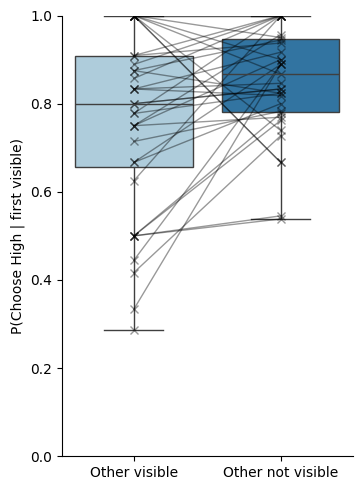

In [24]:
# plot all players data for P(H | H first vis; Other vis)
plot_probability_chose_wall.boxplot_probability_choose_wall(wall_choice_probabilities, ['Other visible', 'Other not visible'], ylabel="P(Choose High | first visible)")

c:\users\tomha\repos\octagon_analysis\plotting\plot_probability_chose_wall.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Condition", y="Probability", data=df, palette="Paired", width=.8)


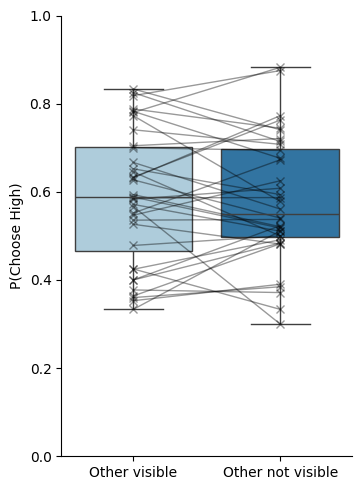

In [37]:
# plot all players data for P(H | Other vis)
plot_probability_chose_wall.boxplot_probability_choose_wall(wall_choice_probabilities2, ['Other visible', 'Other not visible'], ylabel="P(Choose High)")

d:\tom\documents\swc\repos\octagon_analysis\plotting\plot_probability_chose_wall.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Condition", y="Probability", data=df, palette="Paired", width=.8)


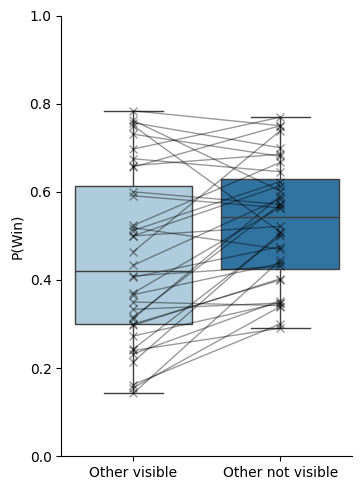

In [85]:
# plot all players data for P(Win | Other vis)
plot_probability_chose_wall.boxplot_probability_choose_wall(wall_choice_probabilities3, ['Other visible', 'Other not visible'], ylabel="P(Win)")

In [50]:
len(filtered_trail_list_a_list)

36

In [88]:
print(plt.rcParams['lines.markersize'])

6.0


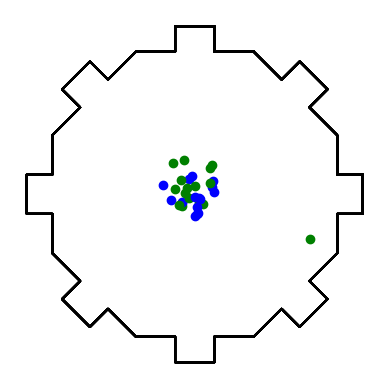

In [89]:
# plot trial start positions for self and other, combining both players in a session, 
# only for trials with Other visible and H visible at trial start
# TODO rewrite cleanly to avoid 
# TODO repeat for the list of trials where Other is NOT visible
# TODO see 250123 octagon meeting notes for how to polish these plots and best use them

chosen_walls_session = np.zeros(len(filtered_trail_list_a_list[0]))  # unused for this analysis

# trial lists
filtered_trail_list_a_list          # all trials with Other and High visible
filtered_trial_list_choice_a_list   # all trials with Other not viisble and High visible

# starting with player 0, the first index 
player_id = 0

# Run the first trial out of the loop to generate the plotted octagon axes
trial = filtered_trail_list_a_list[12][0]
(_, _, 
rotated_flipped_trial, _,
chosen_wall) = fr_funcs.get_trajectory_information_trial(chosen_walls_session, trial=trial, player_id=0)
ax = fr_funcs.plot_player_start_positions(rotated_flipped_trial, chosen_player=player_id, label=False, axes=None)

# now loop the rest of player_id 0 trials
for i, trial in enumerate(filtered_trail_list_a_list[12][1:]):
    (_, _, 
    rotated_flipped_trial, _,
    chosen_wall) = fr_funcs.get_trajectory_information_trial(chosen_walls_session, trial=trial, player_id=player_id)
    ax = fr_funcs.plot_player_start_positions(rotated_flipped_trial, chosen_player=player_id, label=False, axes=ax)
# now loop all player_id 1 trials
player_id = 1
for i, trial in enumerate(filtered_trail_list_a_list[13]):
    (_, _, 
    rotated_flipped_trial, _,
    chosen_wall) = fr_funcs.get_trajectory_information_trial(chosen_walls_session, trial=trial, player_id=player_id)
    ax = fr_funcs.plot_player_start_positions(rotated_flipped_trial, chosen_player=player_id, label=False, axes=ax)


In [55]:
filtered_trail_list_a_list[17][0]['data.trialNum'].unique().item()

13.0